# Part A Convolution Neural Networks
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
## Background Infomation
Convolutional Neural Networks (CNNs) are specialized artificial neural networks designed for processing structured grid data, particularly images. They have become widely popular in computer vision tasks due to their capacity to automatically learn hierarchical features from input data.


## Initializing Libaries

In [218]:
import tensorflow as tf
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import keras_tuner as kt
import visualkeras
from keras.regularizers import l1, l2
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping

## Checking GPU

In [219]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Fixing random seed
Setting the seed for reproducibilty

In [220]:
seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

<!-- ## factors to consider/research

- overfitting (how to prevent it)
    - data augmentation
    - L1 and L2 regulazation
    - dropout layers
    - 
- how does the various parameter of a model (dense layers, parameters of dense layers, activation fucntions, optimizers, learning rate, weigh initilzation, et...)
- affect it eg its accuracy and how does it learn/ will it have vanishing gradient / exploding gradient or any other problems?
- training time and efficiency
    - batch size
-  -->

## Problem statement
Our problem for this assignment is to create a deep learning model to predict vegatables using the dataset on vegatables.

We need to create 2 seperate final models to predict images on 2 different input sizes:
- 31 x 31
- 128 x128 

## Goals of this project
### Generalise to data well
> To make sure our model is able to generalise to data well, we need to __minimize__ the difference between our training accuracy and test accuracy.
### Accuracy
> In order to minimize avoidable bias, it is important for the model to achieve a training set accuracy of at least __85%__ or higher, which signifies a reasonable level of accuracy.

# Importing Datasets

In [367]:
directory_train = './datasets/Dataset for CA1 part A/train'
directory_test = './datasets/Dataset for CA1 part A/test'
directory_validation = './datasets/Dataset for CA1 part A/validation'

def dataset(directory,image_size,seed=seed,batch_size=64,shuffle=True):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        color_mode='grayscale',
        image_size=image_size,
        shuffle=shuffle,
        seed=seed,
        batch_size=batch_size
    )
    return dataset


In [368]:
dataset_train_31 = dataset(directory_train,(31,31))
dataset_test_31 = dataset(directory_test,(31,31))
dataset_validation_31 = dataset(directory_validation,(31,31))

dataset_train_128 = dataset(directory_train,(128,128))
dataset_test_128 = dataset(directory_test,(128,128))
dataset_validation_128 = dataset(directory_validation,(128,128))

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


# EDA
What can we get from our EDA?
- How does the average image look like for each class?
- How is the class distribution?
- How does a sample image look like for each class?


In [223]:
class_labels = [
    "Bean",
    "Bitter Gourd",
    "Bottle Gourd",
    "Brinjal",
    "Broccoli",
    "Cabbage",
    "Capsicum",
    "Carrot",
    "Cauliflower",
    "Cucumber",
    "Papaya",
    "Potato",
    "Pumpkin",
    "Radish",
    "Tomato",
]

In [224]:
for images, labels in dataset_train_31.take(1):
    print("31x31 Batch Shape:", images.shape)
for images, labels in dataset_train_128.take(1):
    print("128x128 Batch Shape:", images.shape)

31x31 Batch Shape: (64, 31, 31, 1)
128x128 Batch Shape: (64, 128, 128, 1)


Our image shapes are 31x31 and 128x128, with a single colour channel.

We have a default batch size of 64, since tf.keras.preprocessing.image_dataset_from_directory requires a default batch size or else the model wont fit properly. Fortunatly we can set our batch size again when we fit our models.

### Visualizing our datasets

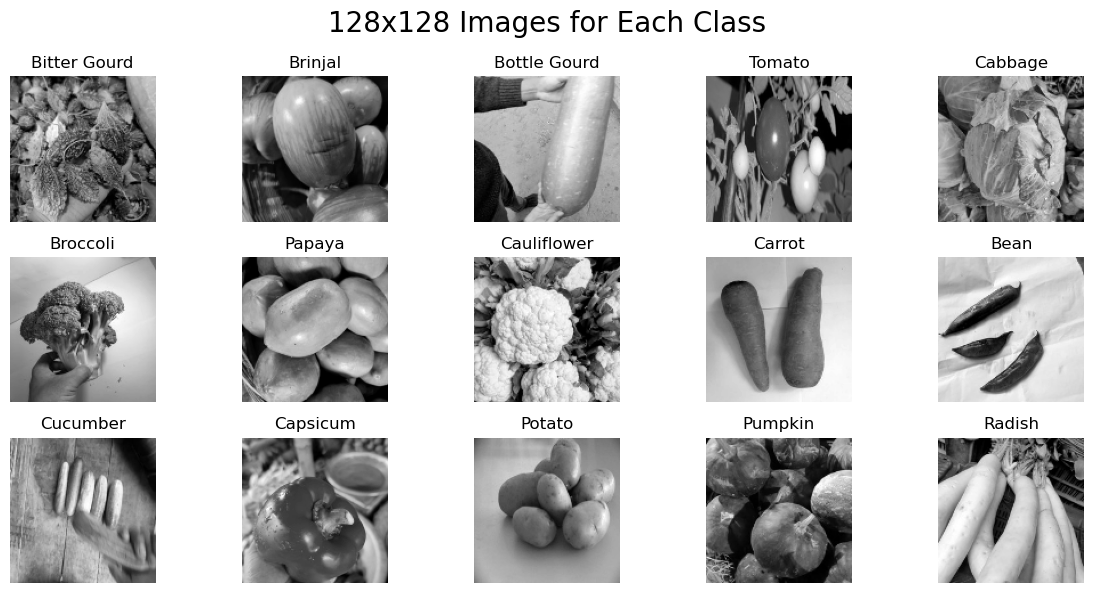

In [225]:
def plot_unique_images(dataset, title, class_labels):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=20)
    unique_images = []  
    unique_labels = []  

    #get unique images
    for images, labels in dataset:
        for i, label in enumerate(labels):
            label_idx = tf.argmax(label).numpy()
            if label_idx not in unique_labels:
                unique_images.append(images[i].numpy().astype("uint8"))
                unique_labels.append(label_idx)

            if len(unique_images) == len(class_labels):
                break 
        if len(unique_images) == len(class_labels):
            break  

    num_images = len(unique_images)
    row = int(np.sqrt(num_images))
    col = int(np.ceil(num_images / row))

    for i in range(num_images):
        ax = plt.subplot(row, col, i + 1)
        plt.imshow(unique_images[i], cmap='gray')
        plt.title(class_labels[unique_labels[i]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_unique_images(dataset_train_128, '128x128 Images for Each Class', class_labels)

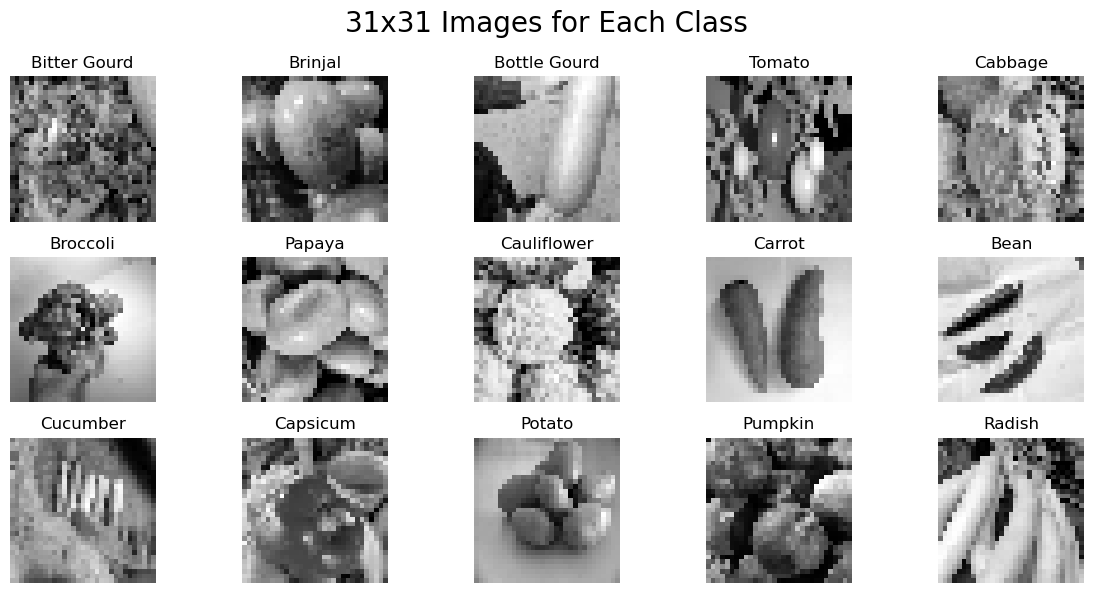

In [226]:
plot_unique_images(dataset_train_31, '31x31 Images for Each Class', class_labels)

Observations:
- We can hardly differentiate some images between classes for images of size 31x31(brocoli,bitter_gourd), hopefully our model can better differeniate these images better than humans!

Now lets get a wider sample range of pictures of every class, to see how diverse the classes are.

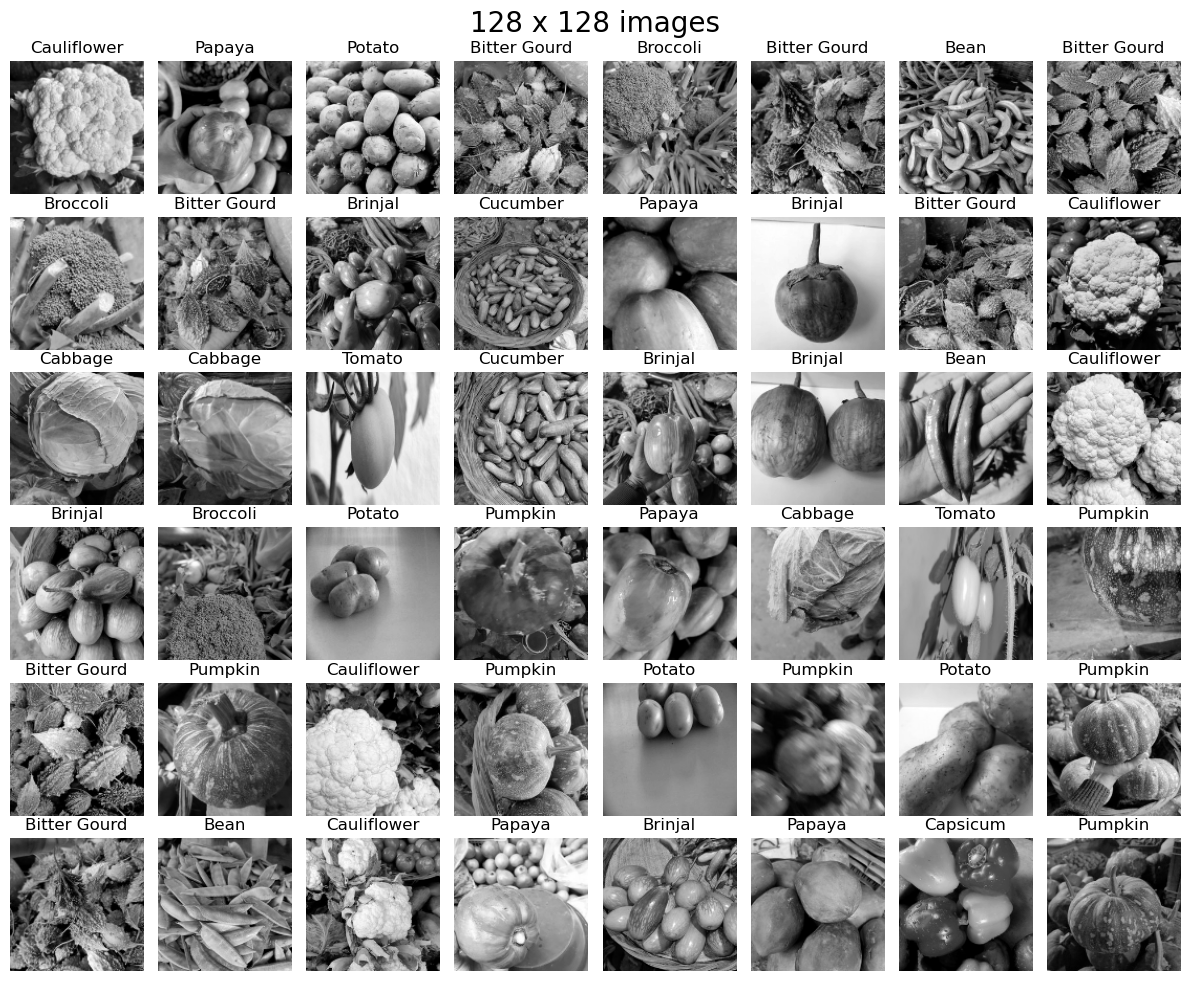

In [227]:
def plot_dataset_huge(amtOfImages, dataset,title,class_labels):
    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=20)
    for images, labels in dataset.take(1):
        num_images = len(images)  

        row = int(np.sqrt(amtOfImages))
        col = int(np.ceil(amtOfImages / row))
            
        for i in range(min(amtOfImages, num_images)):
            ax = plt.subplot(row, col, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.title(class_labels[np.argmax(labels[i])])
            plt.axis("off")

    plt.subplots_adjust(wspace=0.1, hspace=0.01)
    plt.tight_layout()
    plt.show()

plot_dataset_huge(48,dataset_train_128,'128 x 128 images',class_labels)

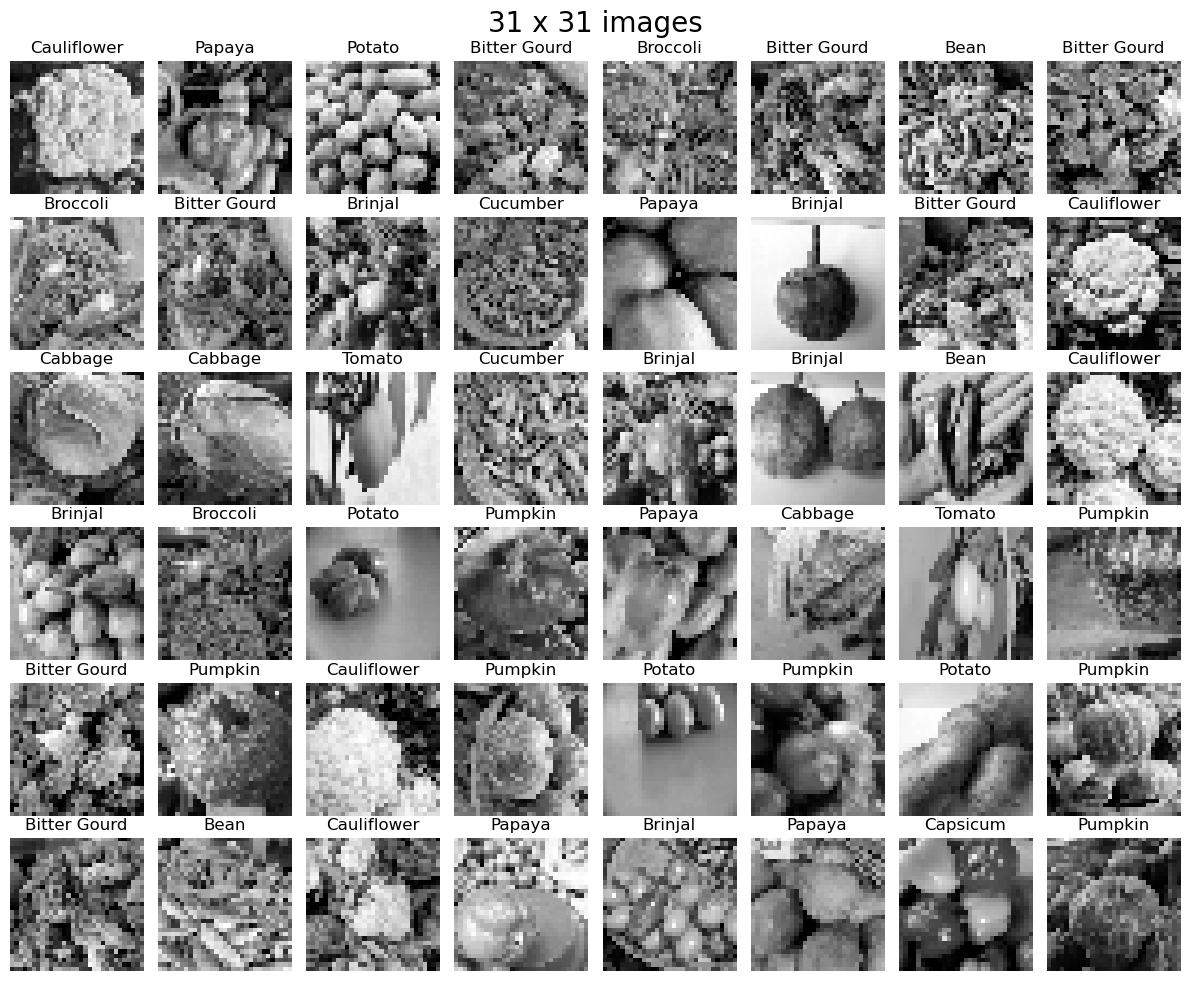

In [228]:
plot_dataset_huge(48,dataset_train_31,'31 x 31 images',class_labels)

Observations:
- Cauliflowers and Potatos are easily differentiable, with potatos usually having a white background and cauliflowers having 

### Class Distribution

In [229]:
class_counts_df = pd.DataFrame(columns=class_labels)

def count_classes(dataset, class_labels):
    class_count = {label: 0 for label in class_labels}
    for _, labels in dataset:
        for label in labels:
            class_name = class_labels[tf.argmax(label)]
            class_count[class_name] += 1
    return class_count

class_counts_df.loc['Validation'] = count_classes(dataset_validation_128, class_labels)
class_counts_df.loc['Training'] = count_classes(dataset_train_128, class_labels)
class_counts_df.loc['Test'] = count_classes(dataset_test_128, class_labels)
class_counts_df.loc['Total Classes'] = class_counts_df.sum()
class_counts_df['Total Datasets'] = class_counts_df.sum(axis=1)

class_counts_df

Bean  Bitter Gourd  Bottle Gourd  Brinjal  Broccoli  Cabbage  \
Validation      200           200           200      200       200      200   
Training        780           720           441      868       750      503   
Test            200           200           200      200       200      200   
Total Classes  1180          1120           841     1268      1150      903   

               Capsicum  Carrot  Cauliflower  Cucumber  Papaya  Potato  \
Validation          200     200          200       200     200     200   
Training            351     256          587       812     566     377   
Test                200     200          200       200     200     200   
Total Classes       751     656          987      1212     966     777   

               Pumpkin  Radish  Tomato  Total Datasets  
Validation         200     200     200            3000  
Training           814     248     955            9028  
Test               200     200     200            3000  
Total Classes     1214     648    1355           15028

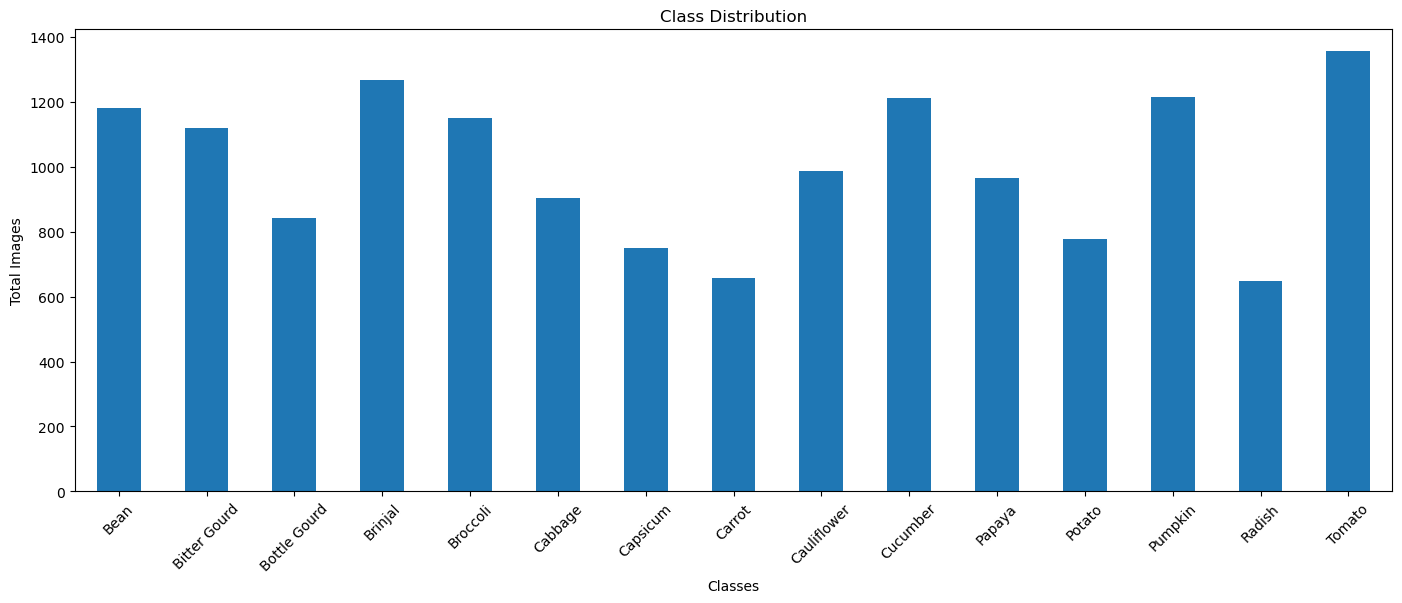

In [230]:
class_counts_df_plot = class_counts_df.drop(['Total Datasets'], axis=1)
class_counts_df_plot = class_counts_df_plot.T
class_counts_df_plot

# Plot the bar graph
class_counts_df_plot['Total Classes'].plot(kind='bar', figsize=(17, 6))
plt.xlabel('Classes')
plt.ylabel('Total Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

We can see that we have an class imbalance for our train dataset. Oh No!! What should we do?
- There are quite alot of solutions for this problem, here are 3 main solutions:
    1. We can __augment our data on the minority classes__(Bottle_gourd, carrots and radish). However we want to also augment our other images classes to prevent overfitting so this is not a good option.
    2. We can __oversample or undersample our minority or majority classes__.However oversampling can lead to overfitting without any data augmentation.
    3. We can __modify the loss function__ to assign different weights to each class, such as increasing the loss weigh for our minority class.


#### Why will we be using differing class weights?
We will be assigning different weights for each class for a few reasons:
- It helps __preserve our existing data__, as in our case we have classes that have a much smaller number of samples (Carrots and Radishs) compared to others.We effectively tell the model to pay more attention to the minority classes. 
- __Prevents overfitting__. As our model is encouraged to strike a balance between minimizing the loss and ensuring that all our classes are predicted accurately. 
- __Simpler than Image oversampling__. Using differing class weights can be more advantagous than image oversampling due to its increased computational costs and potential for overfitting without image augmentation.

In [231]:
class_counts_df_plot['Training'].values

array([780, 720, 441, 868, 750, 503, 351, 256, 587, 812, 566, 377, 814,
       248, 955], dtype=int64)

We will be calculating the class weights using only the train data, as it is the only dataset with imbalanced classes.

In [232]:
class_weights = tf.math.reciprocal(tf.constant(
(class_counts_df_plot['Training'].values).astype(np.float32)))

# Normalize the class weights
class_weights = class_weights / tf.reduce_sum(class_weights)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights.numpy())}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.042979263, 1: 0.046560865, 2: 0.07601774, 3: 0.038621914, 4: 0.04469843, 5: 0.06664775, 6: 0.09550946, 7: 0.13095243, 8: 0.05711043, 9: 0.041285496, 10: 0.05922937, 11: 0.088922605, 12: 0.041184057, 13: 0.1351767, 14: 0.03510348}


#### Another important question to ask is. 
- What are our pixel distributions for our datasets? and what is the std and mean of them? 

In [233]:
def compute_statistics(dataset,title):
    pixel_min = float('inf') 
    pixel_max = float('-inf')
    pixel_sum = 0
    pixel_sum_square = 0
    num_pixels = 0

    for images, _ in dataset:
        for image in images:
            # Calculate min and max pixel values
            pixel_min = min(pixel_min, np.min(image))
            pixel_max = max(pixel_max, np.max(image))

            # Update sum and sum of squares for mean and std calculation
            pixel_sum += np.sum(image)
            pixel_sum_square += np.sum(image ** 2)
            num_pixels += np.prod(image.shape)

    # Calculate mean and std
    pixel_mean = pixel_sum / num_pixels
    pixel_std = np.sqrt((pixel_sum_square / num_pixels) - (pixel_mean ** 2))

    print(title)
    print("Min Pixel Value:", pixel_min)
    print("Max Pixel Value:", pixel_max)
    print("Mean Pixel Value:", pixel_mean)
    print("Standard Deviation:", pixel_std)

    return

compute_statistics(dataset_train_31,'Training Images')
compute_statistics(dataset_test_31,'Test Images')
compute_statistics(dataset_validation_31,'Validation Images')

Training Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 114.34127948859215
Standard Deviation: 55.387912533676406
Test Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 114.66371605098855
Standard Deviation: 55.07995207606749
Validation Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 113.78344607803287
Standard Deviation: 55.49623592897191


- Our pixel values range from 0 to 255, which is expected as grayscale images typically have pixel values ranging from 0 (black) to 255 (white). 
- Our average pixel is around 114, which means that our images are not heavily skewed toward either very dark or very bright values.

### Image Averaging
We will be using only the test and validation datasets for averaging as the train set has class imbalance and may result in inaccurate results.

In [234]:
def calculate_mean_image(datasets, image_size, title):
    pixel_sum = np.zeros((image_size[0], image_size[1]), dtype=np.float64)
    num_images = 0
    mean_images = np.zeros((image_size[0], image_size[1]), dtype=np.float64)

    for dataset in datasets:
        for images, _ in dataset:
            for image in images:
                pixel_sum += np.squeeze(image, axis=-1)
                num_images += 1

    # Calculate the mean image
    mean_image = pixel_sum / num_images
    mean_images = mean_images + mean_image
    
    mean_images = mean_images / len(datasets)

    return mean_images

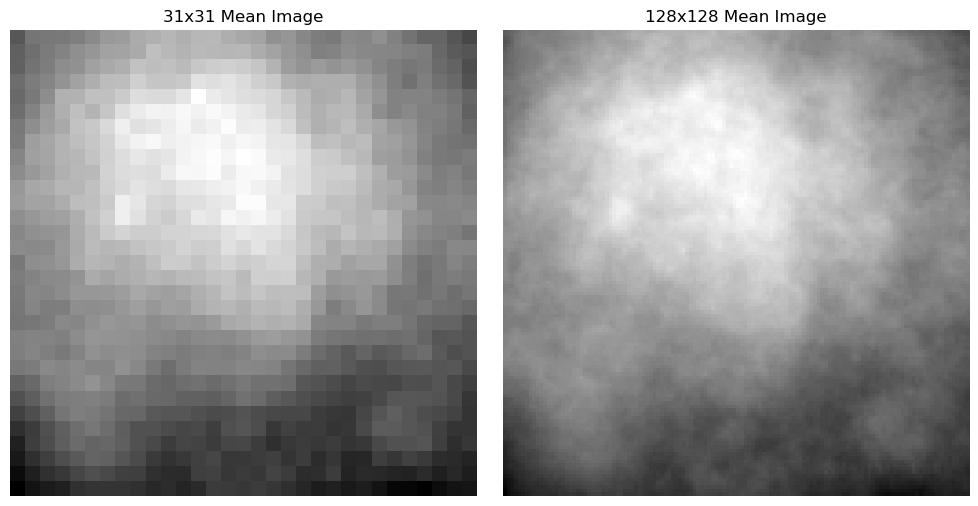

In [235]:
image_size_31 = (31, 31)
image_size_128 = (128, 128)

mean_image_31 = calculate_mean_image([dataset_test_31, dataset_validation_31], image_size_31, 'Average Mean Image (31x31)')
mean_image_128 = calculate_mean_image([dataset_test_128, dataset_validation_128], image_size_128, 'Average Mean Image (128x128)')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mean_image_31, cmap='gray')
plt.title('31x31 Mean Image')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mean_image_128, cmap='gray')
plt.title('128x128 Mean Image')
plt.axis("off")
plt.tight_layout()
plt.show()

The mean image for all the images combined looks like a fog, and we cant really determine any of or classes from this average image.

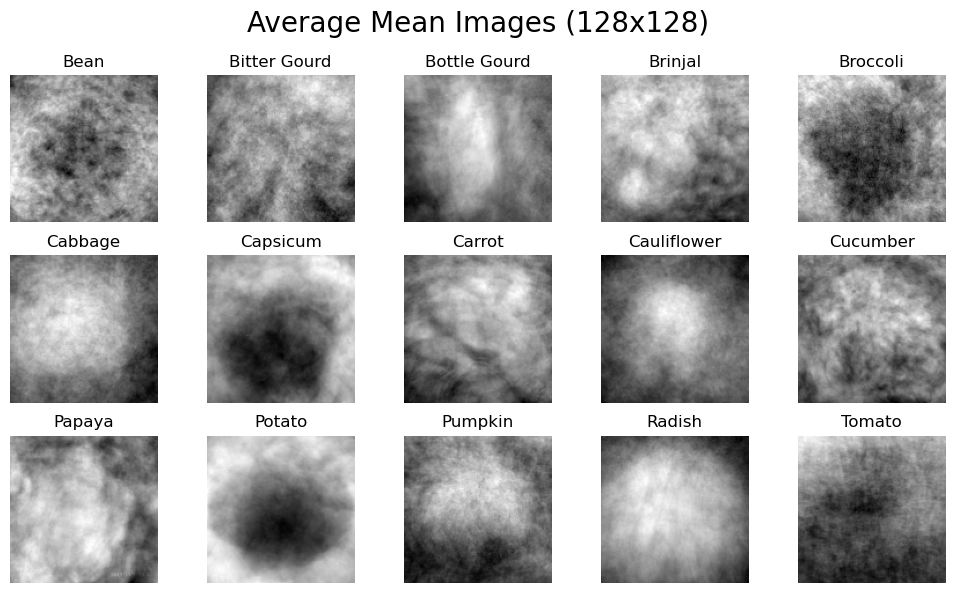

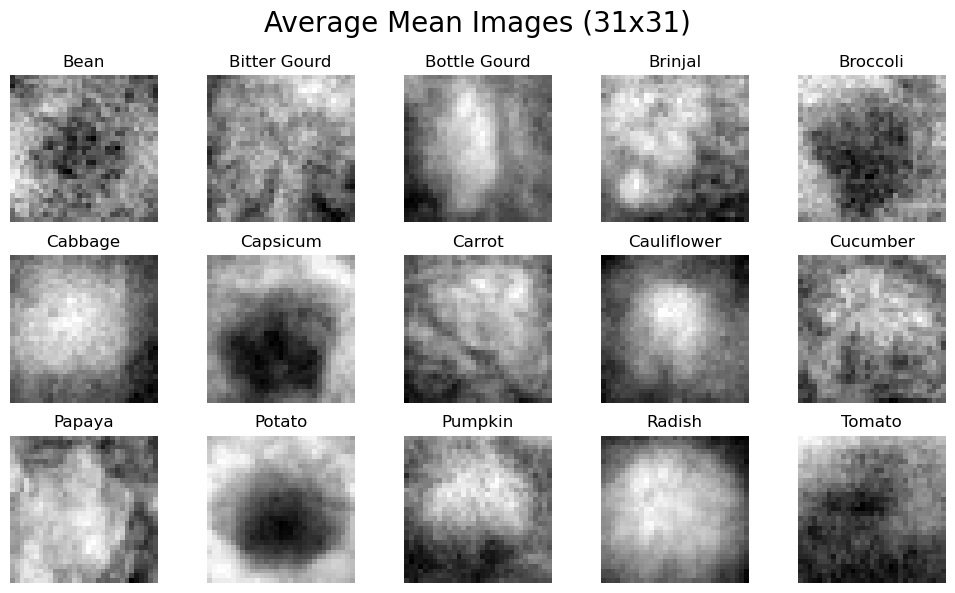

In [236]:
def calculate_class_mean_images(dataset, class_labels, image_size, title,amtOfImages=15):
    class_mean_images = {}  # To store the mean images for each class

    # Initialize mean images for each class
    for class_label in class_labels:
        class_mean_images[class_label] = np.zeros((image_size[0], image_size[1]), dtype=np.float64)

    num_images = 0

    for images, labels in dataset:
        for i, label in enumerate(labels):
            class_label = class_labels[np.argmax(label)]
            class_mean_images[class_label] += np.squeeze(images[i], axis=-1)
            num_images += 1

    num_images = amtOfImages
    row = int(np.sqrt(num_images))
    col = int(np.ceil(num_images / row))

    # Calculate and display the mean image for each class
    plt.figure(figsize=(10, 6))
    plt.suptitle(title, fontsize=20)

    for i, class_label in enumerate(class_labels):
        mean_image = class_mean_images[class_label] / (class_mean_images[class_label].max() + 1e-8)
        plt.subplot(row,col, i + 1)
        plt.imshow(mean_image, cmap='gray')
        plt.title(class_label)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

calculate_class_mean_images(dataset_test_128, class_labels, image_size_128, 'Average Mean Images (128x128)')
calculate_class_mean_images(dataset_test_31, class_labels, image_size_31, 'Average Mean Images (31x31)')

Observations:
- We can see that the pixels for different classes kind of group together to show where the vegetable is. For example, the average image for potato has a cluster of black pixels in the center, roughly outlining a potato.
- However as the images in the dataset are quite complicated, it is quite hard to differentiate out individual classes without labels.

# Data Preprocessing
We need to preprocess our data to help our models to converge faster ,ie lesser time to train. And helps the model to generalise better and prevent it from overfitting.

### Normalizing our images
__Why do we need to normalize our images?__

As normalizing involves scalling the pixel values of our images between 0 and 1 , this results in our images all having a similiar data distribution. Which makes our models benefit from faster convergence during gradient descent and generalising better.

Normalizing the inputs in our context involves calculating the mean and standard deviation of the training dataset and then applying the following formula to each input:
$$
X_{} = \frac{X_{} - μ_{}}{σ_{}}
$$

In [237]:
# use rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_dataset_train_31 = dataset_train_31.map(lambda x, y: (normalization_layer(x), y))

compute_statistics(normalized_dataset_train_31,'Normalised Training Images')

Normalised Training Images
Min Pixel Value: 0.0
Max Pixel Value: 1.0
Mean Pixel Value: 0.448397200505043
Standard Deviation: 0.21720750670021785


We can see that the range of the new normalised pixel values is between 0 - 1 

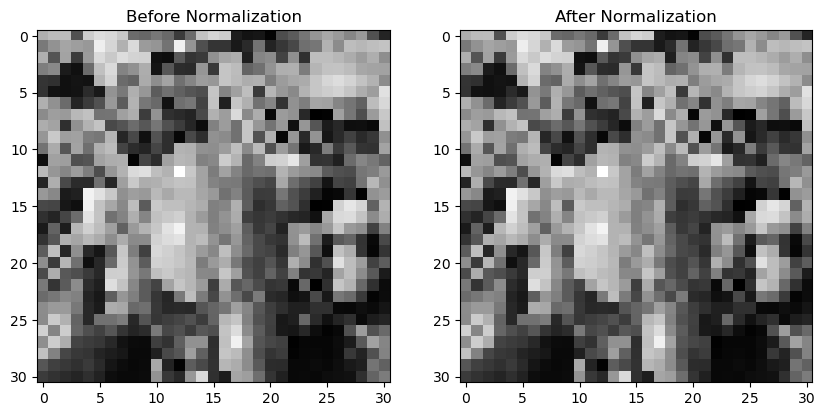

In [238]:
for images, labels in dataset_train_31.take(1):
    original_images = images

normalized_images = normalization_layer(original_images)

original_image = original_images[0]
normalized_image = normalized_images[0]

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(original_image.numpy().squeeze(), cmap='gray')
ax[0].set_title('Before Normalization')

ax[1].imshow(normalized_image.numpy().squeeze(), cmap='gray')
ax[1].set_title('After Normalization')

plt.show()

Observations:
- We can see that normalization dosent significantly affect the visual appearance of our image. Since the original pixel values were already within the same range as before.

### Data Augementation
#### What are image augmentations?
It is a technique that artificially enhances the diversty and variability of our image dataset. It involves applying various transformations to our images such as rotations, flips, scaling, brightness adjustments, and cropping. It is mainly to provide our model with a broader range of training examples which improves its abilty to generalise and predict better on unseen data.
#### Why do we need to augment our images?
There are serveral reasons why we need to augment our images. 
- 1. It increases the amount of images in our train dataset, thus having more "data" for the model to train on. 
- 2. It helps with reducing overfitting,by exposing our model to a wider range of inputs, which promotes robustness and enhances its ability to handle variations.

##### Types of Image Augmentations we will be using:
- flipping (horizontal/ vertically)
- cropping

In [239]:
def augment_images(image, label, size, seed, flip_lr_prob=0.2, flip_ud_prob=0.2):
    image = tf.map_fn(lambda img: tf.image.random_crop(img, size, seed=seed), image)

    # Randomly flip the image left or right based on the flip_lr_prob
    image = tf.cond(tf.random.uniform([]) < flip_lr_prob, 
                    lambda: tf.image.random_flip_left_right(image, seed=seed), 
                    lambda: image)
    # Randomly flip the image up or down based on the flip_ud_prob
    image = tf.cond(tf.random.uniform([]) < flip_ud_prob, 
                    lambda: tf.image.random_flip_up_down(image, seed=seed), 
                    lambda: image)

    return image, label

size_31 = [31, 31, 1] 
size_128 = [128, 128, 1]
train_generator_31 = dataset_train_31.map(lambda image, label: augment_images(image, label, size_31,seed=seed))
train_generator_128 = dataset_train_128.map(lambda image, label: augment_images(image, label, size_128,seed=seed))
#plot the augmented images

We won't have servere data augmentation, as from my testing, servere data augmentation tends to make the model training very unstable and it sometimes even makes the model worse when generalising to our validation data.

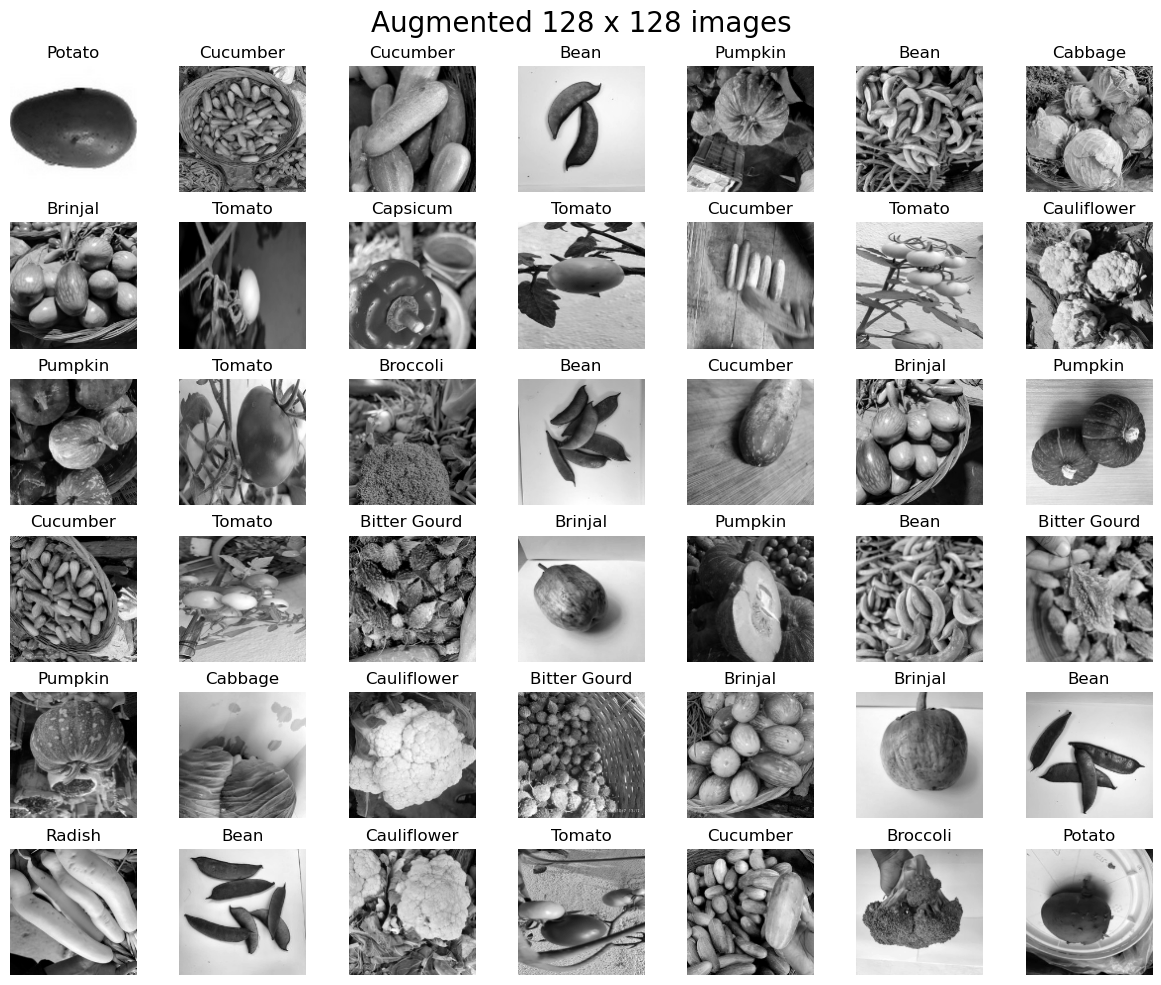

In [240]:
plot_dataset_huge(42,train_generator_128,'Augmented 128 x 128 images',class_labels)

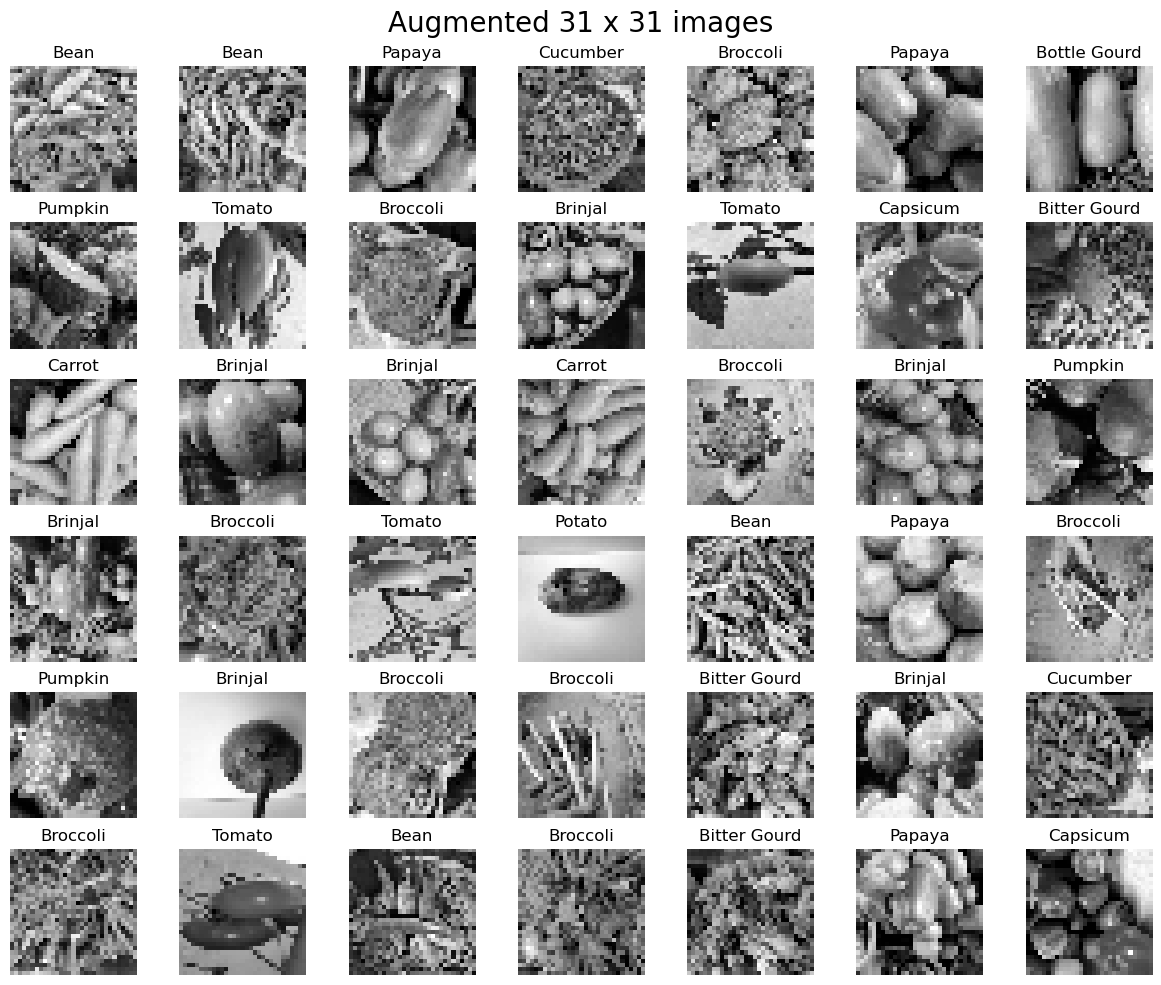

In [241]:
plot_dataset_huge(42,train_generator_31,'Augmented 31 x 31 images',class_labels)

Observations:
- We have successfully augmented some of our images, it is visible that some of the images has been flipped and cropped. This will hopefully introduce more variants into our dataset and enable our model to better generalise to our test and validation datasets.

# Models
### How does a CNN differ from a ANN?
As the name of a CNN suggests, its convolution! As image data is store in arrays, It is deeply inefffcient and unsatisfying to flatten the whole image into an input layer and just feed it through a neural network. With neural network that recognises images having millions of tunable parameters. CNNs help solve that issue, with convolution and pooling layers!
### How does each layer affect our accuracy and efficiency?
We have serveral layers we want to look into here:
#### Convolution Layer(Convo2D)
> - They are basically require in our CNN model to __extract the features__ in our images and can learn hierarchical features.
> - However having too much convolution layers without regularization __can lead to overfitting__  :(
>- Convolutional layers are __computationally intensive__, but their use of shared weights reduces the overall number of parameters compared to fully connected layers, makes them computationally more efficient.  :)
#### Pooling layer
> - Pooling layers downsample feature maps from Convolution layers, reducing its spatial dimensions and computational requirements. :)
>- However excessive pooling may lead to information loss, affecting the model's ability to localize features precisely. :(
> - It increases computational efficiency by reducing the spatial dimensions, which can lead to faster training times and convergence. :)
#### Fully connected layer (Dense)
> - They are the main "brain" of our CNN, they are responsible for combining extracted features for final classification and can capture complex relationships in the data. :)
> - Too many parameters in dense layers can lead to overfitting, especially if our dataset is small which in our case it is. :(
> - Dense layers are alot more computationally expensive due to the large number of parameters, possibly slowing down training times. :( 
#### Dropout layer
> - Dropout layers prevent overfitting by randomly deactivating a fraction of neurons during training, encouraging our CNN to learn more robust features. :)
> - However if the dropout layer is too aggressive, it may prevent the model to learn any meaningful features or patterns, lowering the accuracy. :(


#### Models choosen 
We will be using these models on `31 x 31` and `128 x 128` images
- Convolution 2d Neural Network (base)
- Custom VG16 Network
- Custom ResNet Network

We will be comparing our Custom VG16 Network and Custom Resnet Network with our base model and see how it performs against it.

### Choosing Optimization Algorithm
Our choice of optimization algorithms plays a huge role in training CNN models. The 2 most common optimizers used in TensorFlow are __Adam__ and __Stochastic Gradient Descent (SGD)__. We first need to understand how these 2 optimization algorithms function:

__Adam Optimzer__
- Adam optimization is a stochastic gradient descent method that adapts its learning rates for each network weight __individually__. It is based on adaptive estimation of first-order (mean) and second-order (uncentered variance) moments. Adam is known for its fast convergence and efficiency in handling noisy or sparse gradients [[1]](https://optimization.cbe.cornell.edu/index.php?title=Adam).

__SGD__
- SGD is an  method that updates model parameters based on the gradient of the loss function with respect to those parameters. It is a classic optimization algorithm and is known for its simplicity [[2]](https://arxiv.org/abs/2010.05627).
#### Our choosen Optimization Algorithm : SGD
Why SGD? Eventhough Adam is faster in many cases as compared to SGD, this is due to it updating its learning rates indivdually for each weight and techniques such as coordinate-wise gradient clipping to handle noise effectivly. On the other hand, SGD may out perform Adam in image classification tasks, as Adam takes "shortcuts" where it dosent preserve the fine-grained details to distingush an image.

Therefore we will be using SGD as our optimizer

### Overfitting prevention
To prevent overfitting, we will be using Early Stopping, as it will stop model training once it begins to overfit.
Other strategies include:
- Data Augmentation
- Normalisation
- Dropout layers
- L1 and L2 Regularization


### Does size matter?
Does our input image size really matter? what else were you thinking!?
- Larger input sizes requires more complex models to capture intricate patterns and details in the data. We may need __deeper convolution networks__ to better learn features from our `128 x 128` pictures
- Smaller input sizes eg `31x31` might result in models that __generalize better__. Larger inputs eg `128x128` can lead to overfitting, where the model may memorize details specific to the training set but fail to generalize to new data.

> In summary, smaller sizes tend to give faster training times as models with fewer parameters converge more swiftly during optimization and is able to generalise better. On the other hand, larger sizes introduce increased model complexity, which enables the capture of the finner details and possibly improving performance on tasks requiring fine-grained information. However, this advantage comes at the cost of longer training times and heightened computational demands.


<!-- * compare between augmented/ non-augmented images

params for .fit (steps_per_epoch=None,
    validation_steps=None, verbose,callbacks) -->

## Utilty Functions

In [289]:
def compare_curves(history1, history2, title1, title2):
    plt.figure(figsize=(16, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history1['loss'], 'o-', label='Train Loss ' + title1)
    plt.plot(history1['val_loss'], 'o-', label='Validation Loss ' + title1)
    plt.plot(history2['loss'], '*--', label='Train Loss ' + title2)
    plt.plot(history2['val_loss'], '*--', label='Validation Loss ' + title2)
    plt.title('Loss Curve Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history1['accuracy'], 'o-', label='Train Accuracy ' + title1)
    plt.plot(history1['val_accuracy'], 'o-', label='Validation Accuracy ' + title1)
    plt.plot(history2['accuracy'], '*--', label='Train Accuracy ' + title2)
    plt.plot(history2['val_accuracy'], '*--', label='Validation Accuracy ' + title2)
    plt.title('Accuracy Curve Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_history(history, title):
    plt.figure(figsize=(16, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], 'o-', label='Train Loss')
    plt.plot(history['val_loss'], 'o-', label='Validation Loss')
    plt.title('Loss Curve - ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], 'o-', label='Train Accuracy')
    plt.plot(history['val_accuracy'], 'o-', label='Validation Accuracy')
    plt.title('Accuracy Curve - ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_and_save_model(model, model_name, batch_size, save_dir='./models',save_models=False):
    # Create directory if it doesn't exist
    if save_models:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        # Save the model
        model_path = os.path.join(save_dir, model_name + '.h5')
        #replace the model if it already exists
        if os.path.exists(model_path):
            os.remove(model_path)
        model.save(model_path)
        print('Saved trained model at %s ' % model_path)

        model_history = model.history.history
        if os.path.exists(os.path.join(save_dir, model_name +'_history'+'.json')):
            os.remove(os.path.join(save_dir, model_name + '_history'+'.json'))
        json.dump(model_history, open(os.path.join(save_dir, model_name +'_history'+ '.json'), 'w'))
        print('Saved trained model history at %s ' % os.path.join(save_dir, model_name +'_history'+ '.json'))
    else:
        model_history = model.history.history

    best_val_idx = np.argmax(model_history["val_accuracy"])
    result = {}
    result["Model Name"] = model_name
    result["Epochs"] = len(model_history["loss"])
    result["Batch Size"] = batch_size
    result["Train Loss"] = model_history["loss"][best_val_idx]
    result["Val Loss"] = model_history["val_loss"][best_val_idx]
    result["Train Acc"] = model_history["accuracy"][best_val_idx]
    result["Val Acc"] = model_history["val_accuracy"][best_val_idx]
    result["[Train - Val] Acc"] = result["Train Acc"] - result["Val Acc"]
    result["[Train - Val] Loss"] = result["Train Loss"] - result["Val Loss"]
    result_series = pd.Series(result, name=result["Model Name"])
    print(result_series)
    return

from keras import backend as K
"""
source : https://stackoverflow.com/questions/47680984/does-input-dimension-resolution-affect-the-performance-of-convolutional-neural-n
"""
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Setting Parameters for our model
We will be setting the basic parameters for training our model.
- weight decay 
- steps per epoch 
- learning rate 
- momentum


In [243]:
weight_decay = 0.0005
steps_per_epoch = len(dataset_train_31) # 9028(total training samples) // 64(batch size) = 142
learning_rate = 0.02
momentum = 0.9

## Convo2D Neural Network (Base)

We will be using this model as a base to compare our other 2 models in later down the project. It will be a simple model with 2Convo2D and MaxPooling pairs and 2 hidden dense layers each with 128 neurons. The ReLu activation function will be applyed for the hidden layers and softmax for the output layer. As there are multiple category that we are predicting, we will be using the categorical_crossentropy as our loss function. We will be using both F1 and accuracry to measure our model.

#### Training without Data Augmentation for both `31x31` and` 128x128`

In [244]:
def create_Basemodel(input_shape, learning_rate, momentum, class_weights_dict, dataset_train, dataset_test, steps_per_epoch):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(15, activation='softmax'))
    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])
    model.fit(dataset_train, epochs=150, validation_data=dataset_test, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)
    return model

In [245]:
%%time
BaseModel_31 = create_Basemodel((31,31,1),learning_rate,momentum,class_weights_dict,dataset_train_31,dataset_test_31,steps_per_epoch)

Epoch 1/150


142/142 [==============================] - 3s 12ms/step - loss: 0.1508 - accuracy: 0.0857 - f1_m: 0.0000e+00 - val_loss: 2.7046 - val_accuracy: 0.0933 - val_f1_m: 0.0000e+00
Epoch 2/150
142/142 [==============================] - 2s 10ms/step - loss: 0.1506 - accuracy: 0.1272 - f1_m: 0.0000e+00 - val_loss: 2.7007 - val_accuracy: 0.0870 - val_f1_m: 0.0000e+00
Epoch 3/150
142/142 [==============================] - 2s 10ms/step - loss: 0.1504 - accuracy: 0.1293 - f1_m: 0.0000e+00 - val_loss: 2.6964 - val_accuracy: 0.1013 - val_f1_m: 0.0000e+00
Epoch 4/150
142/142 [==============================] - 2s 11ms/step - loss: 0.1501 - accuracy: 0.1331 - f1_m: 0.0000e+00 - val_loss: 2.6904 - val_accuracy: 0.1183 - val_f1_m: 0.0000e+00
Epoch 5/150
142/142 [==============================] - 2s 12ms/step - loss: 0.1497 - accuracy: 0.1504 - f1_m: 0.0000e+00 - val_loss: 2.6813 - val_accuracy: 0.1360 - val_f1_m: 0.0000e+00
Epoch 6/150
142/142 [==============================] - 2s 12ms/step - loss: 0.1491

In [246]:
%%time
BaseModel_128 =  create_Basemodel((128,128,1),learning_rate,momentum,class_weights_dict,dataset_train_128,dataset_test_128,steps_per_epoch)

Epoch 1/150


142/142 [==============================] - 6s 38ms/step - loss: 0.1501 - accuracy: 0.1097 - f1_m: 0.0000e+00 - val_loss: 2.6740 - val_accuracy: 0.1070 - val_f1_m: 0.0000e+00
Epoch 2/150
142/142 [==============================] - 5s 37ms/step - loss: 0.1462 - accuracy: 0.1369 - f1_m: 0.0000e+00 - val_loss: 2.5610 - val_accuracy: 0.1557 - val_f1_m: 0.0013
Epoch 3/150
142/142 [==============================] - 5s 37ms/step - loss: 0.1376 - accuracy: 0.2045 - f1_m: 0.0045 - val_loss: 2.3882 - val_accuracy: 0.2573 - val_f1_m: 0.0143
Epoch 4/150
142/142 [==============================] - 5s 37ms/step - loss: 0.1279 - accuracy: 0.2913 - f1_m: 0.0171 - val_loss: 2.2287 - val_accuracy: 0.3133 - val_f1_m: 0.0567
Epoch 5/150
142/142 [==============================] - 5s 37ms/step - loss: 0.1182 - accuracy: 0.3499 - f1_m: 0.0758 - val_loss: 2.0560 - val_accuracy: 0.3567 - val_f1_m: 0.1162
Epoch 6/150
142/142 [==============================] - 5s 37ms/step - loss: 0.1086 - accuracy: 0.4025 - f1_m: 

In [247]:
BaseModel_128.summary()
BaseModel_31.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0

Observations:
- We can see that the bigger the input size greatly increases the number of parameters we need to train, thus increasing the training time and likely hood of overfitting in the bigger input size.

In [290]:
# evaluate_and_save_model(model, model.history, 'BaseModel', 64)
evaluate_and_save_model(BaseModel_128, 'BaseModel_128', 64,save_models=False)
evaluate_and_save_model(BaseModel_31, 'BaseModel_31', 64,save_models=False)

Model Name            BaseModel_128
Epochs                           33
Batch Size                       64
Train Loss                 0.001543
Val Loss                   0.981181
Train Acc                  0.995791
Val Acc                    0.786333
[Train - Val] Acc          0.209458
[Train - Val] Loss        -0.979638
Name: BaseModel_128, dtype: object
Model Name            BaseModel_31
Epochs                          77
Batch Size                      64
Train Loss                0.008457
Val Loss                  0.668227
Train Acc                 0.949823
Val Acc                   0.828333
[Train - Val] Acc         0.121489
[Train - Val] Loss        -0.65977
Name: BaseModel_31, dtype: object


In [249]:
baseline_128_history = json.load(open('./models/BaseModel_128_history.json', 'r'))
baseline_31_history = json.load(open('./models/BaseModel_31_history.json', 'r'))

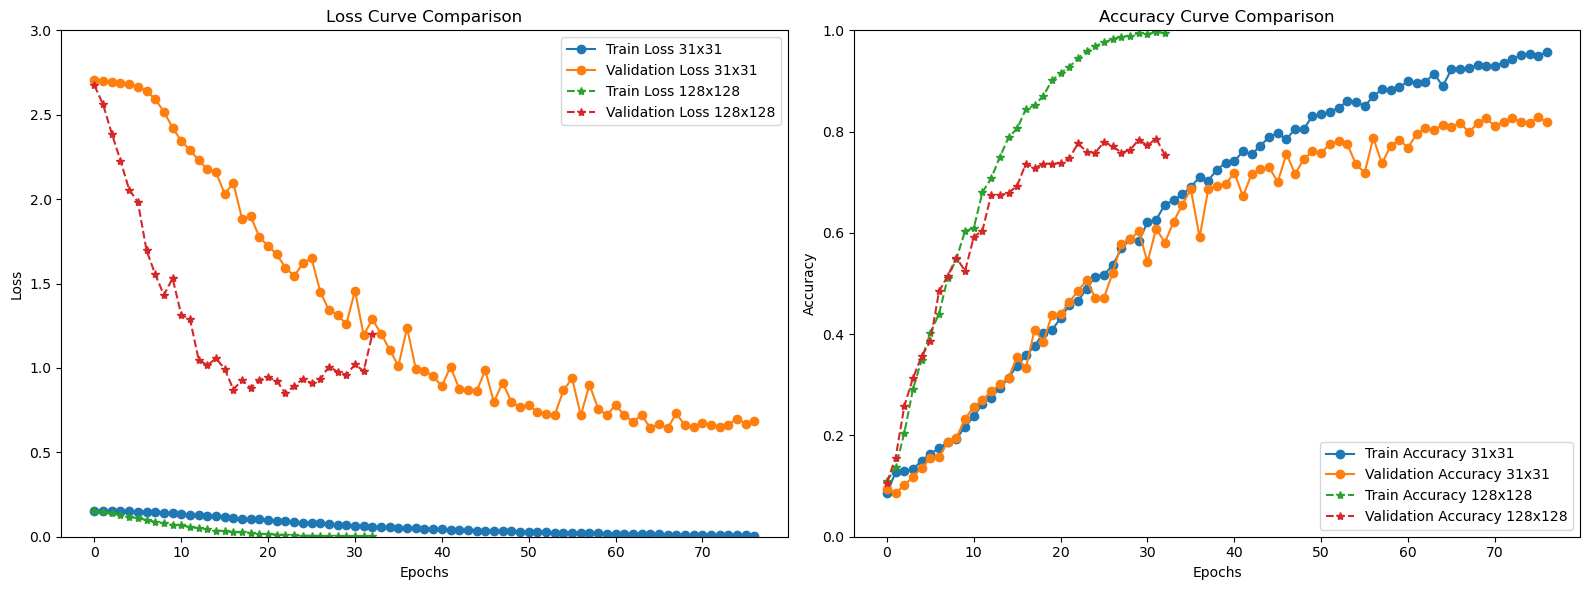

In [250]:
compare_curves(baseline_31_history, baseline_128_history, '31x31', '128x128')

__Obersevations:__

- We can see as when the model increases in epochs, it becomes more generalise and our loss functions starts decreasing as well. However we can see that our model starts to overfit around the 30 epoch mark. We will be comparing and utilising the different overfiting prevention stratergiers latter on in the project.
- As expected , our `128x128` model overfitts alot more and alot faster, thus stopping relatively early during training.

### Training with Data Augmentation
We will now train our baseline model on the dataset that we have augmented

In [251]:
%%time
BaseModel_128_DA = create_Basemodel((128,128,1),learning_rate,momentum,class_weights_dict,train_generator_128,dataset_test_128,steps_per_epoch)

Epoch 1/150


142/142 [==============================] - 6s 39ms/step - loss: 0.1504 - accuracy: 0.1002 - f1_m: 0.0000e+00 - val_loss: 2.6894 - val_accuracy: 0.1050 - val_f1_m: 0.0000e+00
Epoch 2/150
142/142 [==============================] - 5s 37ms/step - loss: 0.1484 - accuracy: 0.1263 - f1_m: 0.0000e+00 - val_loss: 2.6209 - val_accuracy: 0.1107 - val_f1_m: 0.0000e+00
Epoch 3/150
142/142 [==============================] - 5s 38ms/step - loss: 0.1431 - accuracy: 0.1542 - f1_m: 0.0000e+00 - val_loss: 2.5045 - val_accuracy: 0.1923 - val_f1_m: 0.0000e+00
Epoch 4/150
142/142 [==============================] - 5s 37ms/step - loss: 0.1376 - accuracy: 0.2087 - f1_m: 0.0022 - val_loss: 2.3925 - val_accuracy: 0.2300 - val_f1_m: 0.0141
Epoch 5/150
142/142 [==============================] - 6s 44ms/step - loss: 0.1306 - accuracy: 0.2807 - f1_m: 0.0109 - val_loss: 2.2512 - val_accuracy: 0.2987 - val_f1_m: 0.0596
Epoch 6/150
142/142 [==============================] - 6s 38ms/step - loss: 0.1244 - accuracy: 0.3

In [252]:
%%time
BaseModel_31_DA = create_Basemodel((31,31,1),learning_rate,momentum,class_weights_dict,train_generator_31,dataset_test_31,steps_per_epoch)

Epoch 1/150
142/142 [==============================] - 2s 12ms/step - loss: 0.1508 - accuracy: 0.0793 - f1_m: 0.0000e+00 - val_loss: 2.7048 - val_accuracy: 0.0827 - val_f1_m: 0.0000e+00
Epoch 2/150
142/142 [==============================] - 2s 13ms/step - loss: 0.1506 - accuracy: 0.0969 - f1_m: 0.0000e+00 - val_loss: 2.7015 - val_accuracy: 0.1107 - val_f1_m: 0.0000e+00
Epoch 3/150
142/142 [==============================] - 2s 12ms/step - loss: 0.1504 - accuracy: 0.1211 - f1_m: 0.0000e+00 - val_loss: 2.6979 - val_accuracy: 0.1223 - val_f1_m: 0.0000e+00
Epoch 4/150
142/142 [==============================] - 2s 12ms/step - loss: 0.1502 - accuracy: 0.1382 - f1_m: 0.0000e+00 - val_loss: 2.6924 - val_accuracy: 0.1310 - val_f1_m: 0.0000e+00
Epoch 5/150
142/142 [==============================] - 2s 11ms/step - loss: 0.1498 - accuracy: 0.1539 - f1_m: 0.0000e+00 - val_loss: 2.6830 - val_accuracy: 0.1590 - val_f1_m: 0.0000e+00
Epoch 6/150
142/142 [==============================] - 1s 10ms/step - 

In [291]:
evaluate_and_save_model(BaseModel_128_DA,  'BaseModel_128_DA', 64,save_models=False)
evaluate_and_save_model(BaseModel_31_DA, 'BaseModel_31_DA', 64,save_models=False)

Model Name            BaseModel_128_DA
Epochs                              55
Batch Size                          64
Train Loss                     0.00829
Val Loss                      0.602679
Train Acc                     0.957466
Val Acc                          0.842
[Train - Val] Acc             0.115466
[Train - Val] Loss           -0.594389
Name: BaseModel_128_DA, dtype: object
Model Name            BaseModel_31_DA
Epochs                             94
Batch Size                         64
Train Loss                   0.020766
Val Loss                     0.561303
Train Acc                    0.882366
Val Acc                      0.833667
[Train - Val] Acc            0.048699
[Train - Val] Loss          -0.540537
Name: BaseModel_31_DA, dtype: object


In [254]:
DAbaseline_128_history = json.load(open('./models/BaseModel_128_DA_history.json', 'r'))
DAbaseline_31_history = json.load(open('./models/BaseModel_31_DA_history.json', 'r'))

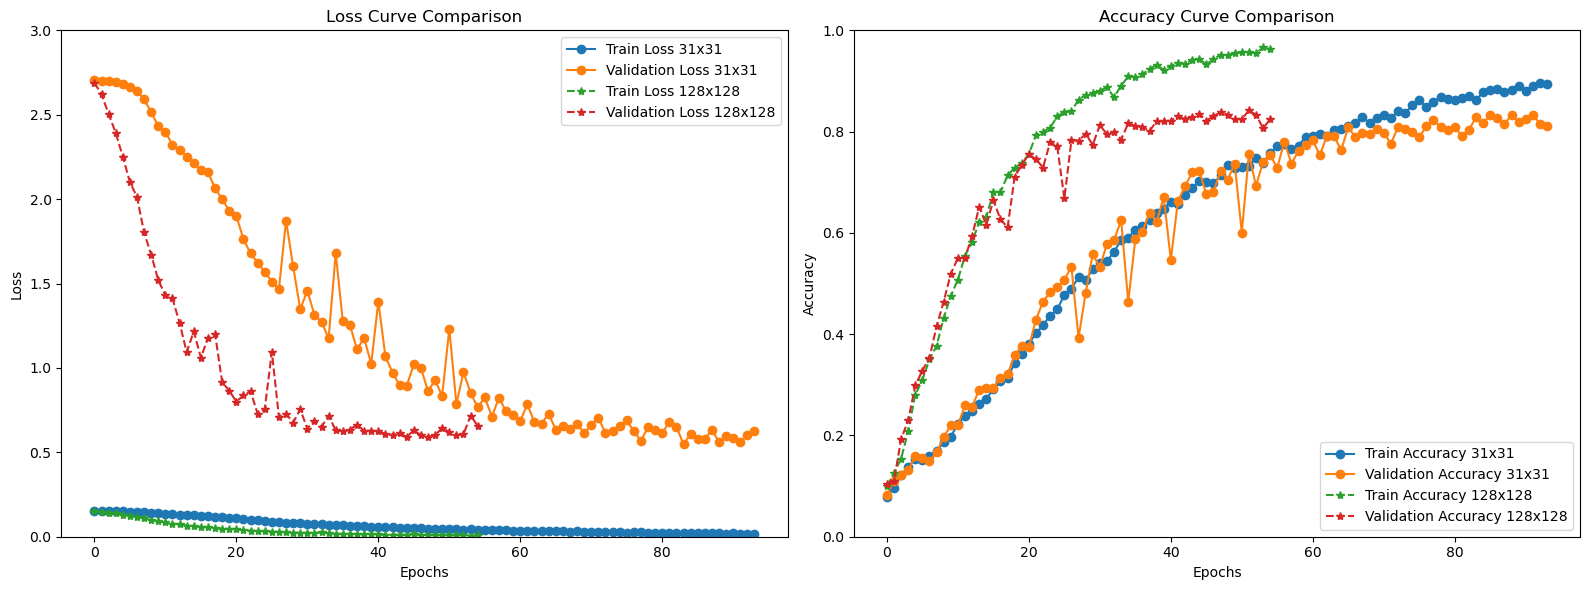

In [255]:
compare_curves(DAbaseline_31_history, DAbaseline_128_history, '31x31', '128x128')

Observations:
- We can see that comparing to the model without data agumentation, the model perfoms worse. However looking at the accuracy and loss graphs, we can see that the model does not overfit as badly as the model trained without data augmentation.
- We still see that the `128x128` model overfitts alot more and faster as compared to our `31x31` model

#### Training with Data Augmentation and Regularization

In [256]:
def create_Basemodel_regularization(input_shape, learning_rate, momentum, class_weights_dict, dataset_train, dataset_test, steps_per_epoch, weight_decay):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))
    model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(Dense(15, activation='softmax'))
    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])
    model.fit(dataset_train, epochs=150, validation_data=dataset_test, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)
    return model

In [257]:
%%time
BaseModel_31_DA_RE = create_Basemodel_regularization((31,31,1),learning_rate,momentum,class_weights_dict,dataset_train_31,dataset_test_31,steps_per_epoch,weight_decay)

Epoch 1/150


142/142 [==============================] - 2s 12ms/step - loss: 0.3631 - accuracy: 0.0463 - f1_m: 0.0000e+00 - val_loss: 2.9083 - val_accuracy: 0.0780 - val_f1_m: 0.0000e+00
Epoch 2/150
142/142 [==============================] - 2s 11ms/step - loss: 0.3511 - accuracy: 0.0757 - f1_m: 0.0000e+00 - val_loss: 2.8917 - val_accuracy: 0.1077 - val_f1_m: 0.0000e+00
Epoch 3/150
142/142 [==============================] - 2s 11ms/step - loss: 0.3398 - accuracy: 0.0804 - f1_m: 0.0000e+00 - val_loss: 2.8754 - val_accuracy: 0.1243 - val_f1_m: 0.0000e+00
Epoch 4/150
142/142 [==============================] - 2s 12ms/step - loss: 0.3290 - accuracy: 0.1032 - f1_m: 0.0000e+00 - val_loss: 2.8571 - val_accuracy: 0.1327 - val_f1_m: 0.0000e+00
Epoch 5/150
142/142 [==============================] - 2s 11ms/step - loss: 0.3187 - accuracy: 0.1177 - f1_m: 0.0000e+00 - val_loss: 2.8357 - val_accuracy: 0.1410 - val_f1_m: 0.0000e+00
Epoch 6/150
142/142 [==============================] - 2s 11ms/step - loss: 0.3087

In [258]:
%%time
BaseModel_128_DA_RE = create_Basemodel_regularization((128,128,1),learning_rate,momentum,class_weights_dict,dataset_train_128,dataset_test_128,steps_per_epoch,weight_decay)

Epoch 1/150


142/142 [==============================] - 6s 37ms/step - loss: 0.3695 - accuracy: 0.0944 - f1_m: 0.0000e+00 - val_loss: 2.8922 - val_accuracy: 0.1210 - val_f1_m: 0.0000e+00
Epoch 2/150
142/142 [==============================] - 5s 36ms/step - loss: 0.3544 - accuracy: 0.1306 - f1_m: 0.0000e+00 - val_loss: 2.7994 - val_accuracy: 0.1320 - val_f1_m: 0.0000e+00
Epoch 3/150
142/142 [==============================] - 5s 36ms/step - loss: 0.3374 - accuracy: 0.1628 - f1_m: 0.0035 - val_loss: 2.7085 - val_accuracy: 0.1573 - val_f1_m: 0.0234
Epoch 4/150
142/142 [==============================] - 5s 35ms/step - loss: 0.3211 - accuracy: 0.2255 - f1_m: 0.0075 - val_loss: 2.5500 - val_accuracy: 0.2683 - val_f1_m: 0.0198
Epoch 5/150
142/142 [==============================] - 5s 36ms/step - loss: 0.3032 - accuracy: 0.2878 - f1_m: 0.0176 - val_loss: 2.3888 - val_accuracy: 0.2990 - val_f1_m: 0.0578
Epoch 6/150
142/142 [==============================] - 5s 36ms/step - loss: 0.2867 - accuracy: 0.3373 - f1

In [292]:
evaluate_and_save_model(BaseModel_128_DA_RE, 'BaseModel_128_DA_RE', 64,save_models=False)
evaluate_and_save_model(BaseModel_31_DA_RE, 'BaseModel_31_DA_RE', 64,save_models=False)

Model Name            BaseModel_128_DA_RE
Epochs                                 43
Batch Size                             64
Train Loss                       0.064911
Val Loss                         0.891881
Train Acc                        0.953146
Val Acc                          0.777333
[Train - Val] Acc                0.175812
[Train - Val] Loss              -0.826971
Name: BaseModel_128_DA_RE, dtype: object
Model Name            BaseModel_31_DA_RE
Epochs                               108
Batch Size                            64
Train Loss                      0.059987
Val Loss                        0.856455
Train Acc                       0.869406
Val Acc                         0.761667
[Train - Val] Acc                0.10774
[Train - Val] Loss             -0.796468
Name: BaseModel_31_DA_RE, dtype: object


In [260]:
DAREbaseline_128_history = json.load(open('./models/BaseModel_128_DA_RE_history.json', 'r'))
DAREbaseline_31_history = json.load(open('./models/BaseModel_31_DA_RE_history.json', 'r'))

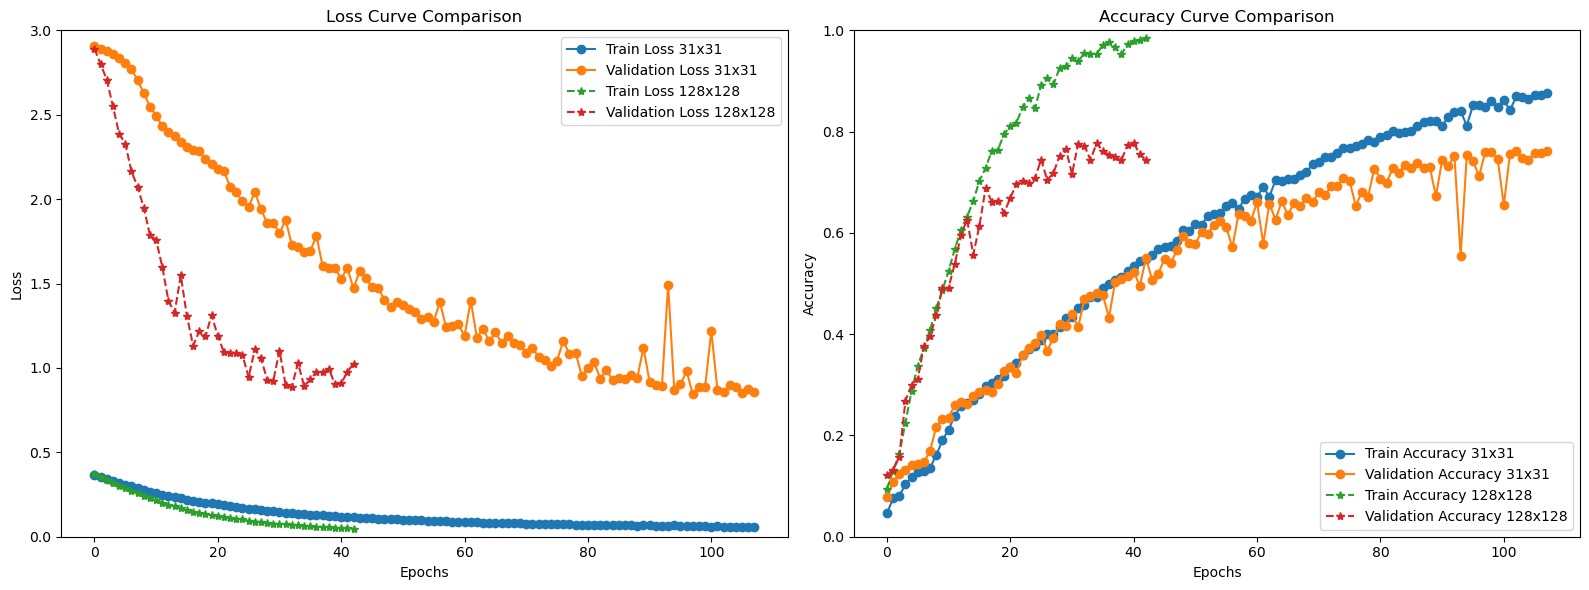

In [261]:
compare_curves(DAREbaseline_31_history, DAREbaseline_128_history, '31x31', '128x128')

Observations:
- We can see that with the inclusion of L2 Regularization, our models tend to not overfit as much as the previous models.
- We can see that our `31x31` model has improved alot compared with training on only augmented images. However, our `128x128` model does not improve at all and even deproves compared with training on only augmented images.

### How can we suit our models to the different sizes?
As mentioned early, bigger input sizes tend to __overfit more__ and have __longer training times__ due to the increased amount of trainable parameters. We also need __deeper networks__ to allow our `128x128` model to better extract complex features.
- We will be using the same stratagies to prevent overfitting in both `31x31` and `128x128` models
- We will introduce more layers for our `128x128` model as compared to our `31x31` model.
- We cant really do anything about the longer training time, unless we reduce our parameters compare to our `31x31` model, however that would defeat the purpose of making our `128x128` model deeper in the first place. :(

## Custom CNN Network
We will be making a custom CNN model based on VGG-16 neural network while tweaking a few parameters. As our baseline model does not seem up to standard with its high overfitting rates even with early stopping.

#### Introduction to VGG-16:
VGG-16 is a convolutional neural network architecture proposed by the Visual Graphics Group (VGG) at the University of Oxford. It was introduced in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition" by Karen Simonyan and Andrew Zisserman in 2014 [[3]](https://arxiv.org/abs/1409.1556). The VGG-16 architecture is known for its simplicity and uniform structure, consisting of 16 weight layers, including 13 convolutional layers and 3 fuly connected layers.

#### Why did i choose VGG-16?
VGG-16 gained popularity for its straightforward and regular design, featuring small 3x3 convolutional filters stacked on top of each other. This uniform architecture makes it easy to implement. Despite its simplicity, VGG-16 demonstrated impressive performance on various image recognition tasks.

#### Architecture of a regular VGG-16 network:

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" alt="VGG-16 Architecture" style="width: 60%;"/>

[Source](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In the VGG-16 architecture, the network is organized into five blocks, each containing a certain number of convolutional layers followed by max-pooling layers. The fully connected layers at the end are responsible for making predictions. The use of small convolutional filters allows the network to learn complex features, and the pooling layers help reduce spatial dimensions.

#### Difference between VGG-16 and ResNet:
While VGG-16 and ResNet are both popular architectures, they differ in their approach to handling information flow. VGG-16 relies on __stacking convolutional layers__, while ResNet introduces __skip connections__ to address the vanishing/exploding gradient problem. In ResNet, the skip connections allow the gradient to flow directly through the network, mitigating issues associated with deep architectures.

### How are we going to build our custom model?
Here are some changes i made to our custom model

__Reducing the amount of filters:__
- Decreases our computational load due to hardware limitations.
- We will be adjusting the number of filters in convolutional layers, reducing the overall number of trainable parameters.

__Batch Normalization:__
- Faster convergence and improved generalization.
- We will be applying Batch normalizing to every ConvoBlock.

__Our Network Depth for different image size:__
- We need to address overfitting for different input sizes (31x31 and 128x128) espically 128x128. As larger input sizes are more prone to overfitting.
- Implementation:
    - For 31x31 input size: Implement a 9-layered VG16 variant.
    - For 128x128 input size: Use a 12-layered VG16 variant to handle larger input dimensions more effectively.

__Including dropout layer:__
- Dropout randomly deactivates a portion of neurons during training, promoting the development of a more robust and generalized model. :)
- We will be integrating dropout layers before the output layer.

__L2 regularization:__
- Mitigate overfitting by penalizing large weights.
- We will be applying L2 regularization to both Conv2D layers and Fully Connected (FC) layers within the network.

Although including batch normalization layer together with a dropout layer is not recomended
<!-- - For each convo block, we will include a x amount of convolution layers, batch normalization layers and activation ReLu layers and at the end have a max pooling layer to reduce the dimensions.
- We will include a dropout layer before the output layer to prevent overfitting
- We will add L2 regularization for our Convo2d layers and Fully connected layers
- 10 layered for 31x31 and 12 layer for 128x128 -->

In [262]:
def ConvoBlock(X, num_convs, num_filters):

    for _ in range(num_convs):
        X = Conv2D(num_filters, (3, 3), padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)

    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

    return X

In [263]:
def create_Custom_model(input_shape, num_classes):
    tf.keras.backend.clear_session()
    if input_shape == (31,31,1):
        num_convs = [3,3,3]
        num_filters = [64,128,256]
    elif input_shape == (128,128,1):
        num_convs = [2,2,2,3,3]
        num_filters = [16,32,64,128,256]
    X_input = Input(input_shape)

    for i in range(len(num_convs)):
        if i == 0:
            X = ConvoBlock(X_input, num_convs[i], num_filters[i])
        else:
            X = ConvoBlock(X, num_convs[i], num_filters[i])

    X = Flatten()(X)

    # Add a dense layer for classification
    X = Dense(256, activation='relu',kernel_regularizer=l2(weight_decay))(X)
    X = Dense(256, activation='relu',kernel_regularizer=l2(weight_decay))(X)
    X = Dropout(0.1)(X)
    X = Dense(num_classes, activation='softmax')(X)

    # Create the model
    model = Model(inputs=X_input, outputs=X)

    return model

CustomModel_128 = create_Custom_model((128, 128, 1), 15)
CustomModel_31 = create_Custom_model((31, 31, 1), 15)

CustomModel_128.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])
CustomModel_31.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])


In [264]:
CustomModel_128.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                             

In [265]:
CustomModel_31.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 31, 31, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 31, 31, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 64)       256       
 hNormalization)                                             

### Training without Data Augmentation

In [266]:
%%time
CustomModel_128.fit(dataset_train_128, epochs=150, validation_data=dataset_test_128, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)

Epoch 1/150


142/142 [==============================] - 10s 62ms/step - loss: 0.4669 - accuracy: 0.3795 - f1_m: 0.2279 - val_loss: 3.0552 - val_accuracy: 0.1193 - val_f1_m: 0.0000e+00
Epoch 2/150
142/142 [==============================] - 8s 59ms/step - loss: 0.3966 - accuracy: 0.6915 - f1_m: 0.6550 - val_loss: 2.0017 - val_accuracy: 0.4380 - val_f1_m: 0.3427
Epoch 3/150
142/142 [==============================] - 8s 59ms/step - loss: 0.3518 - accuracy: 0.8412 - f1_m: 0.8301 - val_loss: 1.5338 - val_accuracy: 0.6123 - val_f1_m: 0.5956
Epoch 4/150
142/142 [==============================] - 8s 59ms/step - loss: 0.3306 - accuracy: 0.8636 - f1_m: 0.8607 - val_loss: 1.2626 - val_accuracy: 0.7280 - val_f1_m: 0.7283
Epoch 5/150
142/142 [==============================] - 8s 59ms/step - loss: 0.3033 - accuracy: 0.9289 - f1_m: 0.9253 - val_loss: 0.9722 - val_accuracy: 0.7707 - val_f1_m: 0.7762
Epoch 6/150
142/142 [==============================] - 8s 59ms/step - loss: 0.2824 - accuracy: 0.9613 - f1_m: 0.9593 

In [267]:
%%time
CustomModel_31.fit(dataset_train_31, epochs=150, validation_data=dataset_test_31, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)

Epoch 1/150


142/142 [==============================] - 5s 25ms/step - loss: 0.4586 - accuracy: 0.3817 - f1_m: 0.2173 - val_loss: 2.7801 - val_accuracy: 0.1723 - val_f1_m: 6.5466e-04
Epoch 2/150
142/142 [==============================] - 3s 24ms/step - loss: 0.3886 - accuracy: 0.6776 - f1_m: 0.6218 - val_loss: 1.4081 - val_accuracy: 0.6863 - val_f1_m: 0.5629
Epoch 3/150
142/142 [==============================] - 3s 24ms/step - loss: 0.3471 - accuracy: 0.8173 - f1_m: 0.8037 - val_loss: 1.7350 - val_accuracy: 0.5420 - val_f1_m: 0.5242
Epoch 4/150
142/142 [==============================] - 3s 24ms/step - loss: 0.3170 - accuracy: 0.8979 - f1_m: 0.8932 - val_loss: 1.1168 - val_accuracy: 0.7330 - val_f1_m: 0.7269
Epoch 5/150
142/142 [==============================] - 3s 24ms/step - loss: 0.2973 - accuracy: 0.9195 - f1_m: 0.9149 - val_loss: 0.7898 - val_accuracy: 0.8397 - val_f1_m: 0.8405
Epoch 6/150
142/142 [==============================] - 3s 24ms/step - loss: 0.2752 - accuracy: 0.9662 - f1_m: 0.9643 -

In [293]:
evaluate_and_save_model(CustomModel_128, 'CustomModel_128', 64,save_models=False)
evaluate_and_save_model(CustomModel_31, 'CustomModel_31', 64,save_models=False)

Model Name            CustomModel_128
Epochs                             68
Batch Size                         64
Train Loss                   0.018694
Val Loss                     0.096466
Train Acc                         1.0
Val Acc                         0.979
[Train - Val] Acc               0.021
[Train - Val] Loss          -0.077772
Name: CustomModel_128, dtype: object
Model Name            CustomModel_31
Epochs                           107
Batch Size                        64
Train Loss                  0.007828
Val Loss                    0.184748
Train Acc                        1.0
Val Acc                        0.952
[Train - Val] Acc              0.048
[Train - Val] Loss          -0.17692
Name: CustomModel_31, dtype: object


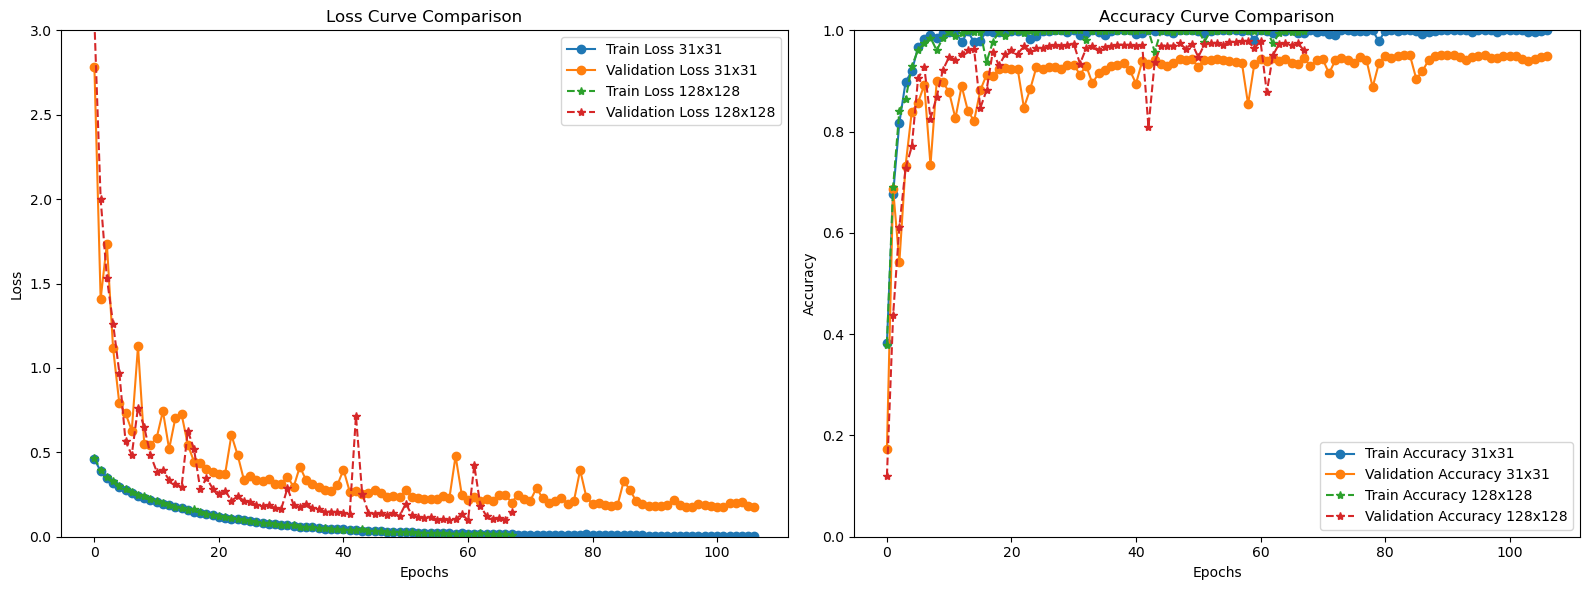

In [269]:
customModel_history_128 = json.load(open('./models/CustomModel_128_history.json', 'r'))
customModel_history_31 = json.load(open('./models/CustomModel_31_history.json', 'r'))
compare_curves(customModel_history_31, customModel_history_128, '31x31', '128x128')

Observations:
- We can see that our efforts to prevent overfitting has paid off
- We can see the fluctutaions due to dropout layer

### Training with Data Augmentation

In [270]:
%%time
CustomModel_128_DA = create_Custom_model((128, 128, 1), 15)
CustomModel_128_DA.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])
CustomModel_128_DA.fit(train_generator_128, epochs=150, validation_data=dataset_test_128, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)

Epoch 1/150


142/142 [==============================] - 10s 61ms/step - loss: 0.4727 - accuracy: 0.3467 - f1_m: 0.1923 - val_loss: 3.2902 - val_accuracy: 0.0703 - val_f1_m: 0.0000e+00
Epoch 2/150
142/142 [==============================] - 8s 58ms/step - loss: 0.4027 - accuracy: 0.6447 - f1_m: 0.5972 - val_loss: 1.7182 - val_accuracy: 0.5480 - val_f1_m: 0.4367
Epoch 3/150
142/142 [==============================] - 8s 58ms/step - loss: 0.3666 - accuracy: 0.7522 - f1_m: 0.7339 - val_loss: 1.3187 - val_accuracy: 0.6607 - val_f1_m: 0.6430
Epoch 4/150
142/142 [==============================] - 8s 58ms/step - loss: 0.3374 - accuracy: 0.8209 - f1_m: 0.8182 - val_loss: 1.0460 - val_accuracy: 0.7493 - val_f1_m: 0.7468
Epoch 5/150
142/142 [==============================] - 8s 58ms/step - loss: 0.3124 - accuracy: 0.8728 - f1_m: 0.8679 - val_loss: 2.9299 - val_accuracy: 0.3740 - val_f1_m: 0.3742
Epoch 6/150
142/142 [==============================] - 8s 58ms/step - loss: 0.2928 - accuracy: 0.8938 - f1_m: 0.8883 

In [271]:
%%time
CustomModel_31_DA = create_Custom_model((31, 31, 1), 15)
CustomModel_31_DA.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])
CustomModel_31_DA.fit(train_generator_31, epochs=150, validation_data=dataset_test_31, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)

Epoch 1/150
142/142 [==============================] - 5s 27ms/step - loss: 0.4665 - accuracy: 0.3095 - f1_m: 0.1313 - val_loss: 2.8437 - val_accuracy: 0.1683 - val_f1_m: 0.0026
Epoch 2/150
142/142 [==============================] - 4s 24ms/step - loss: 0.4033 - accuracy: 0.5836 - f1_m: 0.4956 - val_loss: 2.1785 - val_accuracy: 0.3510 - val_f1_m: 0.2680
Epoch 3/150
142/142 [==============================] - 4s 24ms/step - loss: 0.3642 - accuracy: 0.7113 - f1_m: 0.6815 - val_loss: 1.3861 - val_accuracy: 0.6620 - val_f1_m: 0.6248
Epoch 4/150
142/142 [==============================] - 4s 24ms/step - loss: 0.3348 - accuracy: 0.7816 - f1_m: 0.7702 - val_loss: 1.1378 - val_accuracy: 0.7320 - val_f1_m: 0.7182
Epoch 5/150
142/142 [==============================] - 4s 25ms/step - loss: 0.3112 - accuracy: 0.8322 - f1_m: 0.8230 - val_loss: 0.7999 - val_accuracy: 0.8383 - val_f1_m: 0.8354
Epoch 6/150
142/142 [==============================] - 4s 25ms/step - loss: 0.2903 - accuracy: 0.8662 - f1_m: 

In [294]:
evaluate_and_save_model(CustomModel_128_DA, 'CustomModel_128_DA', 64,save_models=False)
evaluate_and_save_model(CustomModel_31_DA, 'CustomModel_31_DA', 64,save_models=False)

Model Name            CustomModel_128_DA
Epochs                                85
Batch Size                            64
Train Loss                      0.009669
Val Loss                        0.072805
Train Acc                       0.995902
Val Acc                            0.983
[Train - Val] Acc               0.012902
[Train - Val] Loss             -0.063136
Name: CustomModel_128_DA, dtype: object
Model Name            CustomModel_31_DA
Epochs                               70
Batch Size                           64
Train Loss                      0.01923
Val Loss                       0.164061
Train Acc                      0.994683
Val Acc                           0.959
[Train - Val] Acc              0.035683
[Train - Val] Loss             -0.14483
Name: CustomModel_31_DA, dtype: object


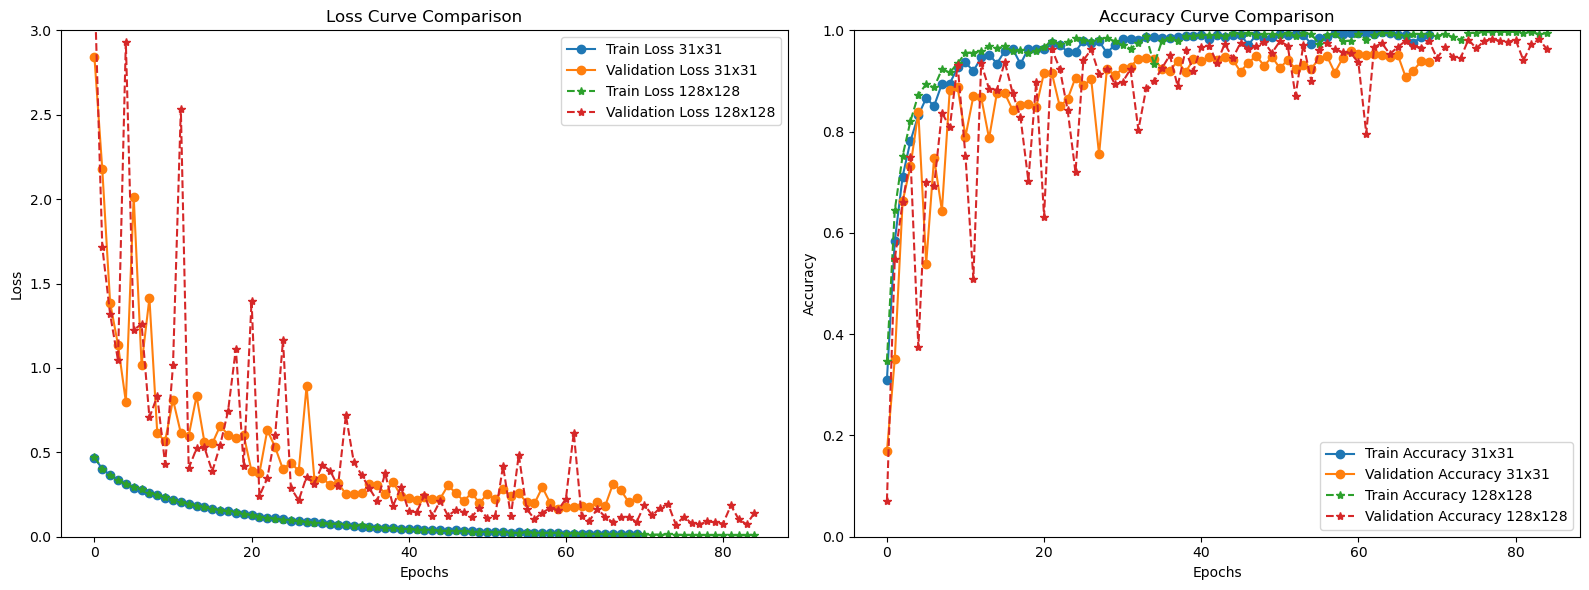

In [273]:
customModel_history_128_DA = json.load(open('./models/CustomModel_128_DA_history.json', 'r'))
customModel_history_31_DA = json.load(open('./models/CustomModel_31_DA_history.json', 'r'))
compare_curves(customModel_history_31_DA, customModel_history_128_DA, '31x31', '128x128')

## Custom Resnet Network
Resnets (Residual Networks) were first introduced in 2015 ,by Microsoft researchers, Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun. In their paper "Deep Residual Learning for Image Recognition" [[4]](https://arxiv.org/abs/1512.03385). They talked on the problem of how deeper neural networks are harder to train and they provide evidence on how Resnets are easier to optimize and learn in much deeper neural networks as compared to other neural networks such as VGG nets during 2015.
#### First of all why Resnet?
Resnet's unqiue architechture of skipping connections backwards from later layers to intital filters, where there are 2 pathways for the gradient to transit back to the inputlayer while tranversing a residual block. allowing us to combat a big problem in neural networks, __vanishing/exploding gradients__. Where when our model network gets too deep and the gradient calculated from backpropagation gradually goes to 0 after multiple applications of the chain rule. Resnet allows us to have deeper and more complex models without encountering the problem of vanishing and exploding gradients.
#### Architechture of a regular residual network
<img src="./images/full_resnet_image.png" style="width: 30%">

[Source](https://www.analyticsvidhya.com/blog/2021/09/building-resnet-34-model-using-pytorch-a-guide-for-beginners/)

Here for example is a 34 layer Resnet, where the main thing that stands out is the skip connections it has. While th architecture is organized into four stages with 3, 4, 6, and 3 residual blocks.The residual blocks consist of 2 stacked convolutional layers with batch normalization and ReLU activations. After the last stage, a global average pooling layer is applied to reduce spatial dimensions. We can see that there are 2 different types of skip connections in this model (dotted and non-dotted lines). An `identity skip connection` and a `projection skip connection`. __What is the difference between the 2?__ In projection skip connections,it is similair to a normal identity skip connection except additional operations(eg. a 1x1 convolutional layer) are applied to the input to match the spatial dimensions of the output of our residual block.

In [274]:
resnet50_example = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(128, 128, 1),
    pooling='avg',
    classes=15,
)
resnet50_example.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

### How are we gonna to modify it to suit our project??
- __Reducing the amount of filters :__
    - A regular Resnet50 has around 23 million trainable parameters, by reducing the filters.
- __Normalizing our inputs :__
    - This helps our model converge faster and help it to generalise better 
- __Network Depth :__
    - For the 31x31 input size, a 12-layered ResNet will be implemented, and for the 128x128 input size, a 16-layered ResNet will be used. 
- __Including dropout layer:__
    - To further combat overfitting, a dropout layer will be incorporated. 
- __L2 regularization:__
    - L2 regularization will be applied to the network's weights. This regularization technique adds a penalty term to the loss function, discouraging large weight values. 

In [275]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def projection_block(X, f, filters, s=2):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides=(s, s))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)

    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [276]:
def CustomResnet(input_shape, classes=15):
    tf.keras.backend.clear_session()
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Define the number of blocks and their filters for each stage
    if input_shape == (31, 31, 1):
        stages = [
            {'blocks': 3, 'filters': [8, 8, 32]},
            {'blocks': 3, 'filters': [16, 16, 64]},
            {'blocks': 3, 'filters': [32, 32, 128]},
            {'blocks': 3, 'filters': [64, 64, 256]}
        ]
    elif input_shape == (128, 128, 1):
        stages = [
            {'blocks': 4, 'filters': [8, 8, 32]},
            {'blocks': 4, 'filters': [16, 16, 64]},
            {'blocks': 4, 'filters': [32, 32, 128]},
            {'blocks': 4, 'filters': [64, 64, 256]}
        ]

    # Create the blocks for each stage
    for i, stage in enumerate(stages):
        X = projection_block(X, f=3, filters=stage['filters'], s=1 if i == 0 else 2)
        for _ in range(stage['blocks']):
            X = identity_block(X, 3, stage['filters'])

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(256, activation='relu',kernel_regularizer=l2(weight_decay))(X)
    X = Dense(256, activation='relu',kernel_regularizer=l2(weight_decay))(X)
    X = Dropout(0.2)(X)
    X = Dense(classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model


CustomResnet_128 = CustomResnet(input_shape=(128, 128, 1), classes=15)
CustomResnet_31 = CustomResnet(input_shape=(31, 31, 1), classes=15)

CustomResnet_128.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])
CustomResnet_31.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])



In [277]:
CustomResnet_128.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                           

In [278]:
CustomResnet_31.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 31, 31, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0

### Training without Data Augmentation

In [279]:
%%time
CustomResnet_128.fit(dataset_train_128, epochs=150, validation_data=dataset_test_128, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)


Epoch 1/150


142/142 [==============================] - 13s 58ms/step - loss: 0.4761 - accuracy: 0.1004 - f1_m: 0.0115 - val_loss: 2.9514 - val_accuracy: 0.0893 - val_f1_m: 6.5466e-04
Epoch 2/150
142/142 [==============================] - 7s 51ms/step - loss: 0.4458 - accuracy: 0.1661 - f1_m: 0.0242 - val_loss: 2.9044 - val_accuracy: 0.1473 - val_f1_m: 6.5466e-04
Epoch 3/150
142/142 [==============================] - 7s 51ms/step - loss: 0.4218 - accuracy: 0.2161 - f1_m: 0.0424 - val_loss: 2.5724 - val_accuracy: 0.2683 - val_f1_m: 0.0701
Epoch 4/150
142/142 [==============================] - 8s 52ms/step - loss: 0.3962 - accuracy: 0.2862 - f1_m: 0.0856 - val_loss: 2.3151 - val_accuracy: 0.3487 - val_f1_m: 0.1433
Epoch 5/150
142/142 [==============================] - 7s 51ms/step - loss: 0.3714 - accuracy: 0.3437 - f1_m: 0.1325 - val_loss: 2.1744 - val_accuracy: 0.3973 - val_f1_m: 0.1900
Epoch 6/150
142/142 [==============================] - 7s 51ms/step - loss: 0.3479 - accuracy: 0.3979 - f1_m: 0.2

In [280]:
%%time
CustomResnet_31.fit(dataset_train_31, epochs=150, validation_data=dataset_test_31, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)

Epoch 1/150


142/142 [==============================] - 13s 42ms/step - loss: 0.4083 - accuracy: 0.0836 - f1_m: 0.0032 - val_loss: 2.9654 - val_accuracy: 0.1033 - val_f1_m: 0.0000e+00
Epoch 2/150
142/142 [==============================] - 5s 35ms/step - loss: 0.3812 - accuracy: 0.1365 - f1_m: 0.0056 - val_loss: 2.9135 - val_accuracy: 0.1187 - val_f1_m: 0.0123
Epoch 3/150
142/142 [==============================] - 5s 35ms/step - loss: 0.3607 - accuracy: 0.1728 - f1_m: 0.0203 - val_loss: 2.6146 - val_accuracy: 0.2047 - val_f1_m: 0.0141
Epoch 4/150
142/142 [==============================] - 5s 34ms/step - loss: 0.3410 - accuracy: 0.2116 - f1_m: 0.0413 - val_loss: 2.4562 - val_accuracy: 0.2567 - val_f1_m: 0.0598
Epoch 5/150
142/142 [==============================] - 5s 36ms/step - loss: 0.3233 - accuracy: 0.2388 - f1_m: 0.0667 - val_loss: 2.3426 - val_accuracy: 0.2870 - val_f1_m: 0.0813
Epoch 6/150
142/142 [==============================] - 5s 37ms/step - loss: 0.3108 - accuracy: 0.2500 - f1_m: 0.0712 

In [295]:
evaluate_and_save_model(CustomResnet_128, 'CustomResnet_128', 64,save_models=False)
evaluate_and_save_model(CustomResnet_31, 'CustomResnet_31', 64,save_models=False)

Model Name            CustomResnet_128
Epochs                              63
Batch Size                          64
Train Loss                    0.019828
Val Loss                      0.668877
Train Acc                     0.977736
Val Acc                       0.833333
[Train - Val] Acc             0.144403
[Train - Val] Loss           -0.649049
Name: CustomResnet_128, dtype: object
Model Name            CustomResnet_31
Epochs                             43
Batch Size                         64
Train Loss                   0.100193
Val Loss                     1.243305
Train Acc                    0.660944
Val Acc                      0.633667
[Train - Val] Acc            0.027277
[Train - Val] Loss          -1.143112
Name: CustomResnet_31, dtype: object


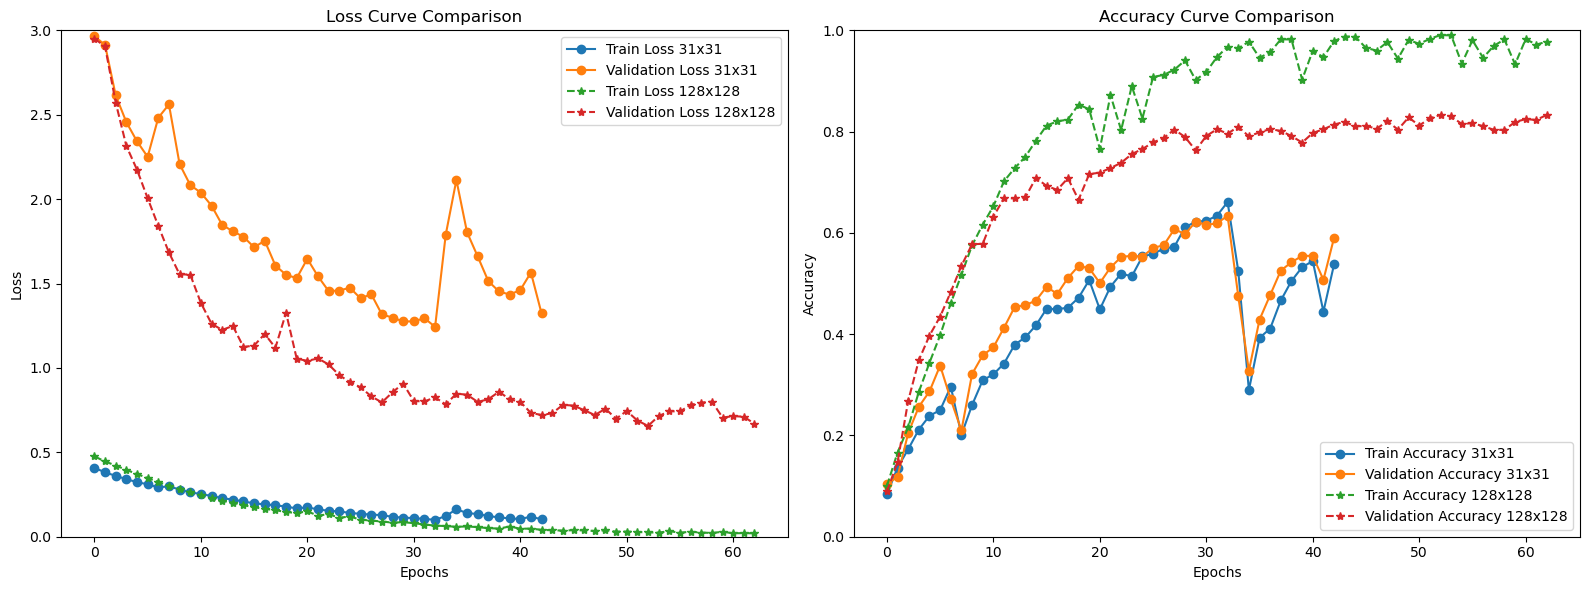

In [282]:
customResnet_history_128 = json.load(open('./models/CustomResnet_128_history.json', 'r'))
customResnet_history_31 = json.load(open('./models/CustomResnet_31_history.json', 'r'))
compare_curves(customResnet_history_31, customResnet_history_128, '31x31', '128x128')

### Training with Data Augmentation

In [283]:
%%time
CustomResnet_128_DA = CustomResnet(input_shape=(128, 128, 1), classes=15)
CustomResnet_128_DA.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])
CustomResnet_128_DA.fit(train_generator_128, epochs=150, validation_data=dataset_test_128, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)

Epoch 1/150
142/142 [==============================] - 13s 60ms/step - loss: 0.4775 - accuracy: 0.1011 - f1_m: 0.0032 - val_loss: 2.9629 - val_accuracy: 0.1137 - val_f1_m: 0.0020
Epoch 2/150
142/142 [==============================] - 7s 52ms/step - loss: 0.4497 - accuracy: 0.1501 - f1_m: 0.0067 - val_loss: 2.8134 - val_accuracy: 0.1687 - val_f1_m: 0.0117
Epoch 3/150
142/142 [==============================] - 7s 52ms/step - loss: 0.4254 - accuracy: 0.2000 - f1_m: 0.0162 - val_loss: 2.6343 - val_accuracy: 0.2503 - val_f1_m: 0.0174
Epoch 4/150
142/142 [==============================] - 7s 51ms/step - loss: 0.4020 - accuracy: 0.2442 - f1_m: 0.0362 - val_loss: 2.4462 - val_accuracy: 0.3077 - val_f1_m: 0.0334
Epoch 5/150
142/142 [==============================] - 7s 51ms/step - loss: 0.3778 - accuracy: 0.2975 - f1_m: 0.0683 - val_loss: 2.2762 - val_accuracy: 0.3517 - val_f1_m: 0.1529
Epoch 6/150
142/142 [==============================] - 7s 51ms/step - loss: 0.3552 - accuracy: 0.3451 - f1_m:

In [284]:
%%time
CustomResnet_31_DA = CustomResnet(input_shape=(31, 31, 1), classes=15)
CustomResnet_31_DA.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])
CustomResnet_31_DA.fit(train_generator_31, epochs=150, validation_data=dataset_test_31, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)


Epoch 1/150
142/142 [==============================] - 9s 41ms/step - loss: 0.4045 - accuracy: 0.0955 - f1_m: 0.0045 - val_loss: 3.0522 - val_accuracy: 0.0810 - val_f1_m: 0.0000e+00
Epoch 2/150
142/142 [==============================] - 5s 36ms/step - loss: 0.3775 - accuracy: 0.1411 - f1_m: 0.0039 - val_loss: 2.8274 - val_accuracy: 0.1517 - val_f1_m: 0.0191
Epoch 3/150
142/142 [==============================] - 5s 36ms/step - loss: 0.3595 - accuracy: 0.1721 - f1_m: 0.0056 - val_loss: 2.6186 - val_accuracy: 0.2157 - val_f1_m: 0.0059
Epoch 4/150
142/142 [==============================] - 5s 35ms/step - loss: 0.3424 - accuracy: 0.1818 - f1_m: 0.0126 - val_loss: 2.5044 - val_accuracy: 0.2343 - val_f1_m: 0.0181
Epoch 5/150
142/142 [==============================] - 5s 35ms/step - loss: 0.3295 - accuracy: 0.1916 - f1_m: 0.0098 - val_loss: 2.4244 - val_accuracy: 0.2540 - val_f1_m: 0.0345
Epoch 6/150
142/142 [==============================] - 5s 35ms/step - loss: 0.3125 - accuracy: 0.2311 - f1

In [296]:
evaluate_and_save_model(CustomResnet_128_DA, 'CustomResnet_128_DA', 64,save_models=False)
evaluate_and_save_model(CustomResnet_31_DA, 'CustomResnet_31_DA', 64,save_models=False)

Model Name            CustomResnet_128_DA
Epochs                                 93
Batch Size                             64
Train Loss                       0.016132
Val Loss                         0.420006
Train Acc                        0.958463
Val Acc                             0.889
[Train - Val] Acc                0.069463
[Train - Val] Loss              -0.403874
Name: CustomResnet_128_DA, dtype: object
Model Name            CustomResnet_31_DA
Epochs                                67
Batch Size                            64
Train Loss                      0.085078
Val Loss                        1.080718
Train Acc                       0.589389
Val Acc                         0.672333
[Train - Val] Acc              -0.082945
[Train - Val] Loss              -0.99564
Name: CustomResnet_31_DA, dtype: object


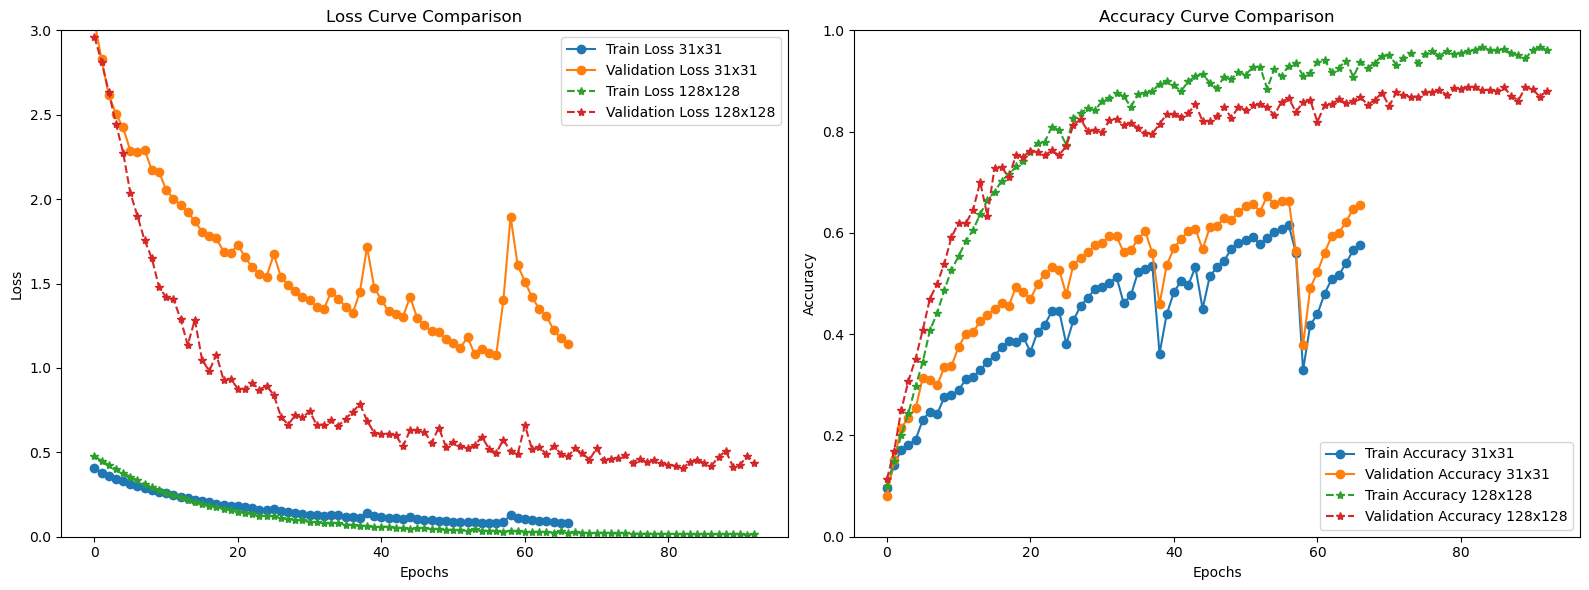

In [286]:
customResnet_history_128_DA = json.load(open('./models/CustomResnet_128_DA_history.json', 'r'))
customResnet_history_31_DA = json.load(open('./models/CustomResnet_31_DA_history.json', 'r'))
compare_curves(customResnet_history_31_DA, customResnet_history_128_DA, '31x31', '128x128')

## Choosen model

In [300]:
def load_and_evaluate_model(model_name, batch_size, save_dir='./models'):
    model_history = json.load(open(os.path.join(save_dir, model_name +'_history'+ '.json'), 'r'))

    best_val_idx = np.argmax(model_history["val_accuracy"])
    result = {}
    result["Model Name"] = model_name
    result["Epochs"] = len(model_history["loss"])
    result["Batch Size"] = batch_size
    result["Train Loss"] = model_history["loss"][best_val_idx]
    result["Val Loss"] = model_history["val_loss"][best_val_idx]
    result["Train Acc"] = model_history["accuracy"][best_val_idx]
    result["Val Acc"] = model_history["val_accuracy"][best_val_idx]
    result["[Train - Val] Acc"] = result["Train Acc"] - result["Val Acc"]
    result["[Train - Val] Loss"] = result["Train Loss"] - result["Val Loss"]
    result_series = pd.Series(result, name=result["Model Name"])
    return result_series
def highlight_row(s, row_index):
    return ['background-color: green' if s.name == row_index else '' for _ in s]


evaluation_31_df = pd.DataFrame()

model_names_31 = ['BaseModel_31', 'Basemodel_31_DA', 'Basemodel_31_DA_RE', 'CustomModel_31', 'CustomModel_31_DA', 'CustomResnet_31', 'CustomResnet_31_DA']

batch_size = 64

# Load and evaluate each model and append the result to the DataFrame
for model_name in model_names_31:
    result_series = load_and_evaluate_model(model_name, batch_size)
    evaluation_31_df = pd.concat([evaluation_31_df, result_series], axis=1)

evaluation_31_df = evaluation_31_df.T.reset_index()
evaluation_31_df = evaluation_31_df.drop(['index'], axis=1)
evaluation_31_df = evaluation_31_df.style.apply(highlight_row, row_index=4, axis=1)
display(evaluation_31_df)

In [301]:
model_names_128 = ['BaseModel_128', 'Basemodel_128_DA', 'Basemodel_128_DA_RE', 'CustomModel_128', 'CustomModel_128_DA', 'CustomResnet_128', 'CustomResnet_128_DA']

evaluation_128_df = pd.DataFrame()
for model_name in model_names_128:
    result_series = load_and_evaluate_model(model_name, batch_size)
    evaluation_128_df = pd.concat([evaluation_128_df, result_series], axis=1)

evaluation_128_df = evaluation_128_df.T.reset_index()
evaluation_128_df = evaluation_128_df.drop(['index'], axis=1)
evaluation_128_df = evaluation_128_df.style.apply(highlight_row, row_index=4, axis=1)
display(evaluation_128_df)

We can see that our Custom CNN model based on VGGnet architechture trained on data augmeneted images, has the best overall results. With very good train and validation accuracy with not alot of overfitting.

#### Why does our custom model perform better then Resnet eventhough it is proven to be better?
This could be because our Custom Resnet model only has 12 layers (for 128x128) as compared to current Resnet models such as Resnet34 and ResNet 50. The advantage of Resnet over other models is that it can handle much deeper neural network layers due to its skip connections. However due to hardware and time limitations, we are not able to train a large Custom Resnet model of 34 to 50 layers deep. While our custom model based on VGG architechture, eventhough it has less layers, it proves to be a robust performer. While simple, this simplicity makes our model easier to train with limited hardware resources and time constraints.

# Model Improvement 
We will be using Keras Tuner to tune certain settings in our model. The parameters we are going to tune are:
- Weight Decay
    - allows us to find the optimal regularization strength, striking a balance between model complexity and generalization.
- Amount of Neurons is our dense layers
    - As too few neurons may result in underfitting, while too many may lead to overfitting. So we need to find a balance of model complexity
- Learning rate
    - If the learning rate is too high, our model might overshoot the optimal weights, if it's too low, the model may converge very slowly or get stuck in local minima. 

In [327]:
from keras_tuner import HyperModel
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

class CustomHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        tf.keras.backend.clear_session()
        if self.input_shape == (31,31,1):
            num_convs = [3,3,3]
            num_filters = [64,128,256]
        elif self.input_shape == (128,128,1):
            num_convs = [2,2,2,3,3]
            num_filters = [16,32,64,128,256]
        X_input = layers.Input(self.input_shape)

        for i in range(len(num_convs)):
            if i == 0:
                X = ConvoBlock(X_input, num_convs[i], num_filters[i])
            else:
                X = ConvoBlock(X, num_convs[i], num_filters[i])

        X = layers.Flatten()(X)

        X = layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu', kernel_regularizer=l2(hp.Float("weight_decay",min_value = 0.00001,max_value=0.001)))(X)
        X = layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu', kernel_regularizer=l2(hp.Float("weight_decay",min_value = 0.00001,max_value=0.001)))(X)
        X = layers.Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.3, step=0.1))(X)
        X = layers.Dense(self.num_classes, activation='softmax')(X)

        # Create the model
        model = tf.keras.Model(inputs=X_input, outputs=X)

        # Compile the model
        model.compile(optimizer=tf.keras.optimizers.SGD(hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3,1e-4]), momentum=0.9),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model

In [331]:
customTunedModel_128 = CustomHyperModel(input_shape=(128, 128, 1), num_classes=15)
customTunedModel_31 = CustomHyperModel(input_shape=(31, 31, 1), num_classes=15)

tuner_128 = kt.Hyperband(customTunedModel_128, 
                        objective='val_accuracy', 
                        max_epochs=100,
                        factor=3,
                        project_name='TunedModel_128')

tuner_31 = kt.Hyperband(customTunedModel_31,
                        objective='val_accuracy',
                        max_epochs=100,
                        factor=3,
                        project_name='TunedModel_31')


In [332]:
tuner_128.search(train_generator_128, epochs=100, validation_data=dataset_test_128, class_weight=class_weights_dict,steps_per_epoch=steps_per_epoch,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')])

Trial 252 Complete [00h 10m 53s]
val_accuracy: 0.9733333587646484

Best val_accuracy So Far: 0.9853333234786987
Total elapsed time: 05h 20m 38s


In [333]:
tuner_128.results_summary(3)

Results summary
Results in .\TunedModel_128
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 0206 summary
Hyperparameters:
dense_units: 192
weight_decay: 0.0006602248964913205
dropout_rate: 0.1
learning_rate: 0.1
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0204
Score: 0.9853333234786987

Trial 0145 summary
Hyperparameters:
dense_units: 256
weight_decay: 0.0003630695567053518
dropout_rate: 0.1
learning_rate: 0.1
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142
Score: 0.9783333539962769

Trial 0232 summary
Hyperparameters:
dense_units: 64
weight_decay: 0.0004988939209611291
dropout_rate: 0.1
learning_rate: 0.01
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0227
Score: 0.9756666421890259


In [334]:
tuner_31.search(train_generator_31, epochs=100, validation_data=dataset_test_31, class_weight=class_weights_dict,steps_per_epoch=steps_per_epoch)

Trial 254 Complete [00h 05m 51s]
val_accuracy: 0.5139999985694885

Best val_accuracy So Far: 0.9789999723434448
Total elapsed time: 02h 42m 20s


In [335]:
tuner_31.results_summary(3)

Results summary
Results in .\TunedModel_31
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 0234 summary
Hyperparameters:
dense_units: 256
weight_decay: 0.0008862468274995598
dropout_rate: 0.1
learning_rate: 0.1
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0231
Score: 0.9789999723434448

Trial 0146 summary
Hyperparameters:
dense_units: 192
weight_decay: 0.000682698997366627
dropout_rate: 0.1
learning_rate: 0.1
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 0.9779999852180481

Trial 0249 summary
Hyperparameters:
dense_units: 64
weight_decay: 0.0002798940181868567
dropout_rate: 0.2
learning_rate: 0.1
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9746666550636292


In [336]:
final_model_128 = tuner_128.get_best_models(num_models=1)[0]
final_model_31 = tuner_31.get_best_models(num_models=1)[0]
final_model_128.save('./models/final_model_128.h5')
final_model_31.save('./models/final_model_31.h5')

In [337]:
final_model_128.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                             

In [338]:
final_model_31.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 31, 31, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 31, 31, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 64)       256       
 hNormalization)                                             

# Final Model
Now, we are checking how well our final model works. To make sure it's good at handling new data, we want the accuracy on the validation dataset to be similar to what we saw on the test set. This helps us trust that the model is not just good on the data it learned from but also on new, unseen examples. :)

## Evaluating our Model on our validation dataset

In [357]:
final_model_128 = tf.keras.models.load_model('./models/final_model_128.h5')
final_model_31 = tf.keras.models.load_model('./models/final_model_31.h5')

In [358]:
final_model_128.evaluate(dataset_validation_128)

47/47 [==============================] - 1s 19ms/step - loss: 0.0659 - accuracy: 0.9837


[0.06585882604122162, 0.9836666584014893]

In [359]:
final_model_31.evaluate(dataset_validation_31)

47/47 [==============================] - 1s 12ms/step - loss: 0.0692 - accuracy: 0.9820


[0.06922943890094757, 0.9819999933242798]

We can see that our accuracy on the validation dataset is __98.37%__ for our `128x128` model and __98.20%__ for our `31x31` model. These results are very close to our test dataset results, especially for our `128x128` model. With hyperparemeter tuning, our `31x31` model improves over 3% on the validation data. This shows that our model not only does not overfit it is able to generalise very well to unseen data. :)

## Classification Report

In [379]:
# Not shuffling dataset to avoid confusion in the classification report
dataset_validation_128 = dataset(directory_validation, (128, 128), shuffle=False)
dataset_validation_31 = dataset(directory_validation, (31, 31), shuffle=False)

# Assuming `class_labels` is a list of your class labels
class_labels = [str(label) for label in class_labels]

y_true_128 = np.concatenate([y for x, y in dataset_validation_128], axis=0)
y_true_31 = np.concatenate([y for x, y in dataset_validation_31], axis=0)
test_preds_probs_128 = final_model_128.predict(dataset_validation_128)
test_preds_probs_31 = final_model_31.predict(dataset_validation_31)
test_pred_128 = np.argmax(test_preds_probs_128, axis=1)
test_pred_31 = np.argmax(test_preds_probs_31, axis=1)

report_128 = classification_report(
    np.argmax(y_true_128, axis=1), test_pred_128, target_names=class_labels
)

report_31 = classification_report(
    np.argmax(y_true_31, axis=1), test_pred_31, target_names=class_labels
)
print("Classification Report (128x128):")
print(report_128)

Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
47/47 [==============================] - 0s 8ms/step
Classification Report (128x128):
              precision    recall  f1-score   support

        Bean       0.99      0.98      0.99       200
Bitter Gourd       0.99      0.99      0.99       200
Bottle Gourd       0.99      0.98      0.98       200
     Brinjal       0.99      0.99      0.99       200
    Broccoli       1.00      0.98      0.99       200
     Cabbage       0.99      0.98      0.98       200
    Capsicum       0.98      0.99      0.99       200
      Carrot       0.97      1.00      0.99       200
 Cauliflower       0.99      1.00      0.99       200
    Cucumber       0.98      0.99      0.98       200
      Papaya       0.99      0.94      0.97       200
      Potato       0.95      0.99      0.97       200
     Pumpkin       0.96      0.98      0.97       200
      Radish       0.99      0.98      0.99       200
      Tomato       

In [380]:
print("Classification Report (31x31):")
print(report_31)

Classification Report (31x31):
              precision    recall  f1-score   support

        Bean       0.98      0.98      0.98       200
Bitter Gourd       0.99      0.99      0.99       200
Bottle Gourd       1.00      0.98      0.99       200
     Brinjal       0.98      0.97      0.97       200
    Broccoli       0.97      0.98      0.98       200
     Cabbage       0.97      0.96      0.97       200
    Capsicum       0.99      0.99      0.99       200
      Carrot       0.99      0.99      0.99       200
 Cauliflower       0.98      0.98      0.98       200
    Cucumber       0.99      0.99      0.99       200
      Papaya       0.97      0.98      0.98       200
      Potato       0.99      0.97      0.98       200
     Pumpkin       0.98      0.99      0.98       200
      Radish       0.99      0.96      0.97       200
      Tomato       0.98      0.98      0.98       200

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      

From looking at the classification report, we can see that
- The distribution of classes in our validation dataset is perfectly balanced
- Our model does generalise to our classes very well and do not appear to be biased to any 1 class.
- The overall accuracy of 98% in both models indicates that they perform exceptionally well in correctly classifying vegetable images. :)

## Error Analysis
We can look and analyze our model's mistakes

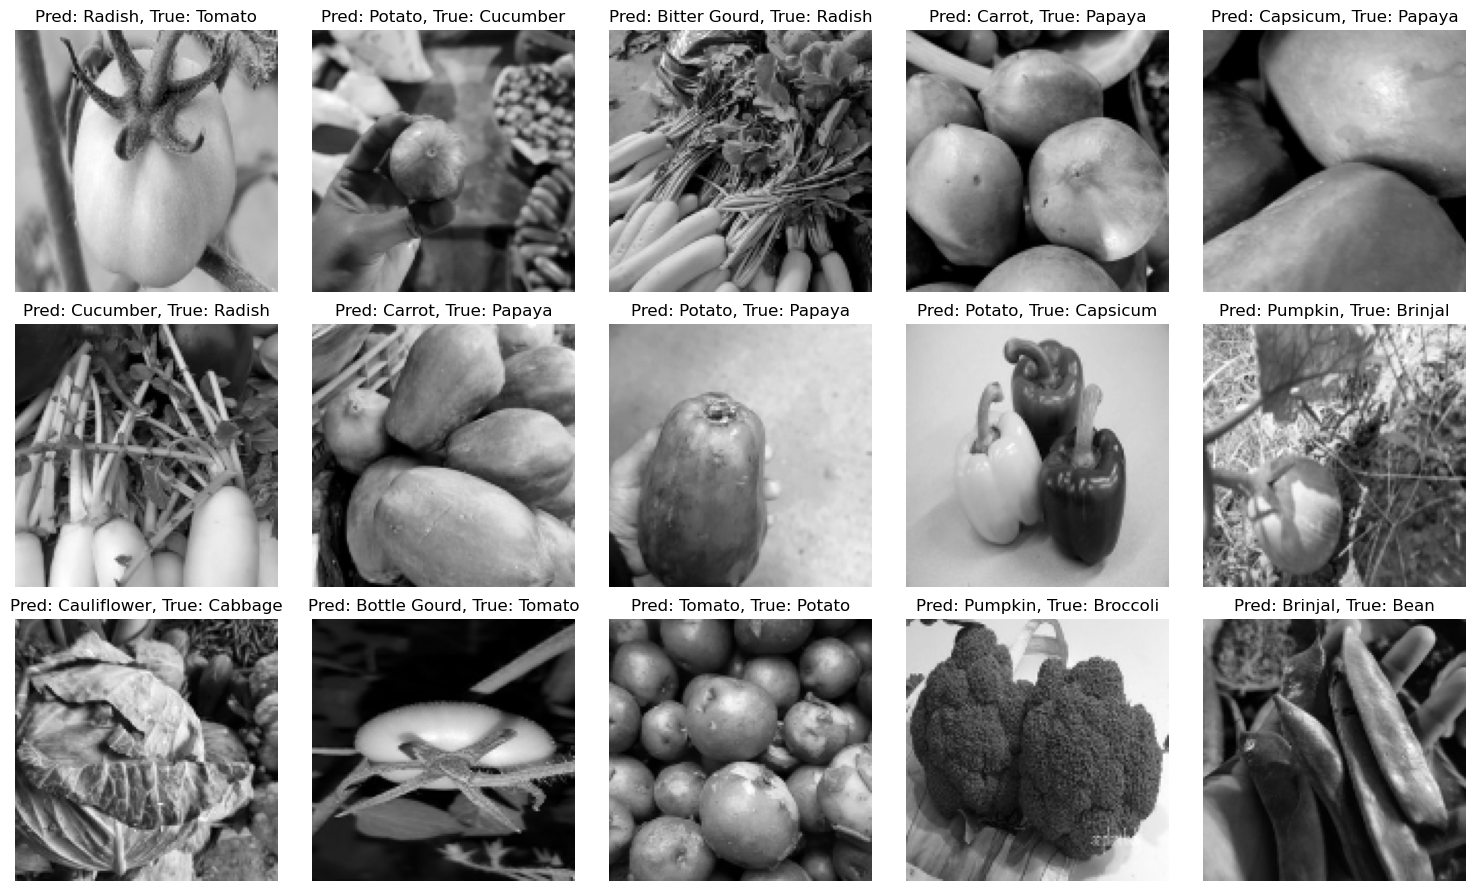

In [398]:
import random
incorrect_indices_128 = np.nonzero(test_pred_128 != np.argmax(y_true_128, axis=1))[0]
incorrect_indices_31 = np.nonzero(test_pred_31 != np.argmax(y_true_31, axis=1))[0]

incorrect_images_128 = np.concatenate([x for x, y in dataset_validation_128], axis=0)[incorrect_indices_128]
incorrect_images_31 = np.concatenate([x for x, y in dataset_validation_31], axis=0)[incorrect_indices_31]

incorrect_data_128 = list(zip(incorrect_indices_128, incorrect_images_128))
random.shuffle(incorrect_data_128)
incorrect_indices_128, incorrect_images_128 = zip(*incorrect_data_128)

incorrect_data_31 = list(zip(incorrect_indices_31, incorrect_images_31))
random.shuffle(incorrect_data_31)
incorrect_indices_31, incorrect_images_31 = zip(*incorrect_data_31)

# Now you can plot the shuffled incorrect images as before
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
for i, ax in enumerate(axes.flat):
    if i < len(incorrect_indices_128):
        ax.imshow(incorrect_images_128[i], cmap='gray')
        ax.set_title(f"Pred: {class_labels[test_pred_128[incorrect_indices_128[i]]]}, True: {class_labels[np.argmax(y_true_128[incorrect_indices_128[i]])]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

When looking at the sample examples of our `128x128` model's predictions:
- It appears that the model's mistakes are sometimes quite dumb, where it mistakes a papaya as a carrot. 
- This suggests that we need to make our 128x128 model deeper and more complex to extract more prominent features from our vegatables.
- However some of its mistakes are reasonable, such as mistaking papayas for potato in black and white. Which highlights the impact of factors beyond our model's architecture, such as variations in color and image quality.

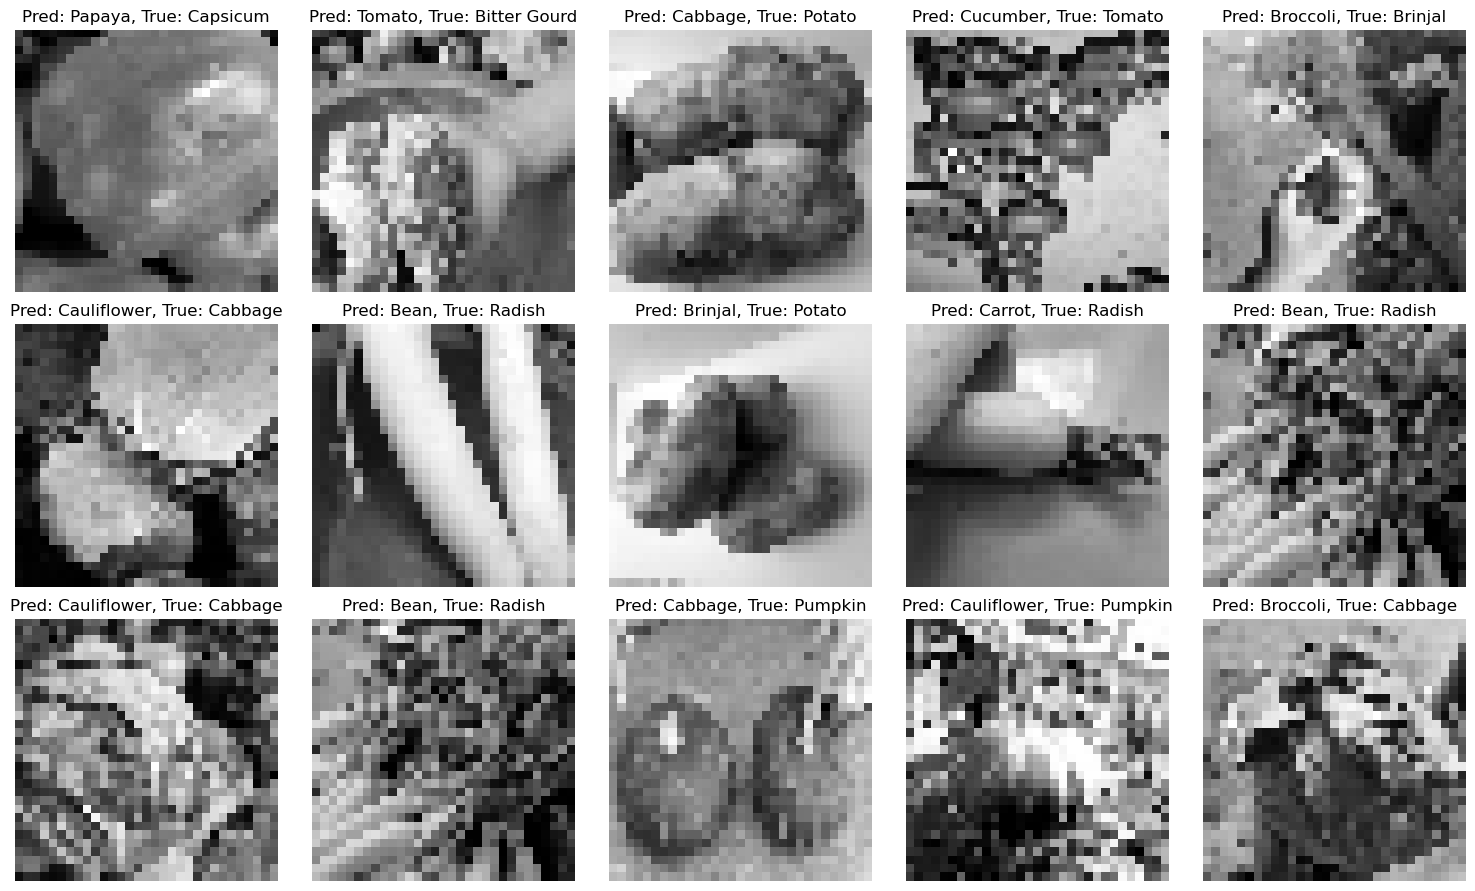

In [399]:

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
for i, ax in enumerate(axes.flat):
    if i < len(incorrect_indices_31):
        ax.imshow(incorrect_images_31[i], cmap='gray')
        ax.set_title(f"Pred: {class_labels[test_pred_31[incorrect_indices_31[i]]]}, True: {class_labels[np.argmax(y_true_31[incorrect_indices_31[i]])]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

When looking at the sample examples of our `31x31` model's predictions:
- The low pixel resolution makes it ambguious even to a human what the correct class is.
- At such a size the details and distinct features that characterize different vegetables might be reduced or even lost.

So it is reasonable for the model to make such mistakes. Thus our model is doing quite well as some errors are because the images are naturally hard to interpret.

### Final Model Visualization

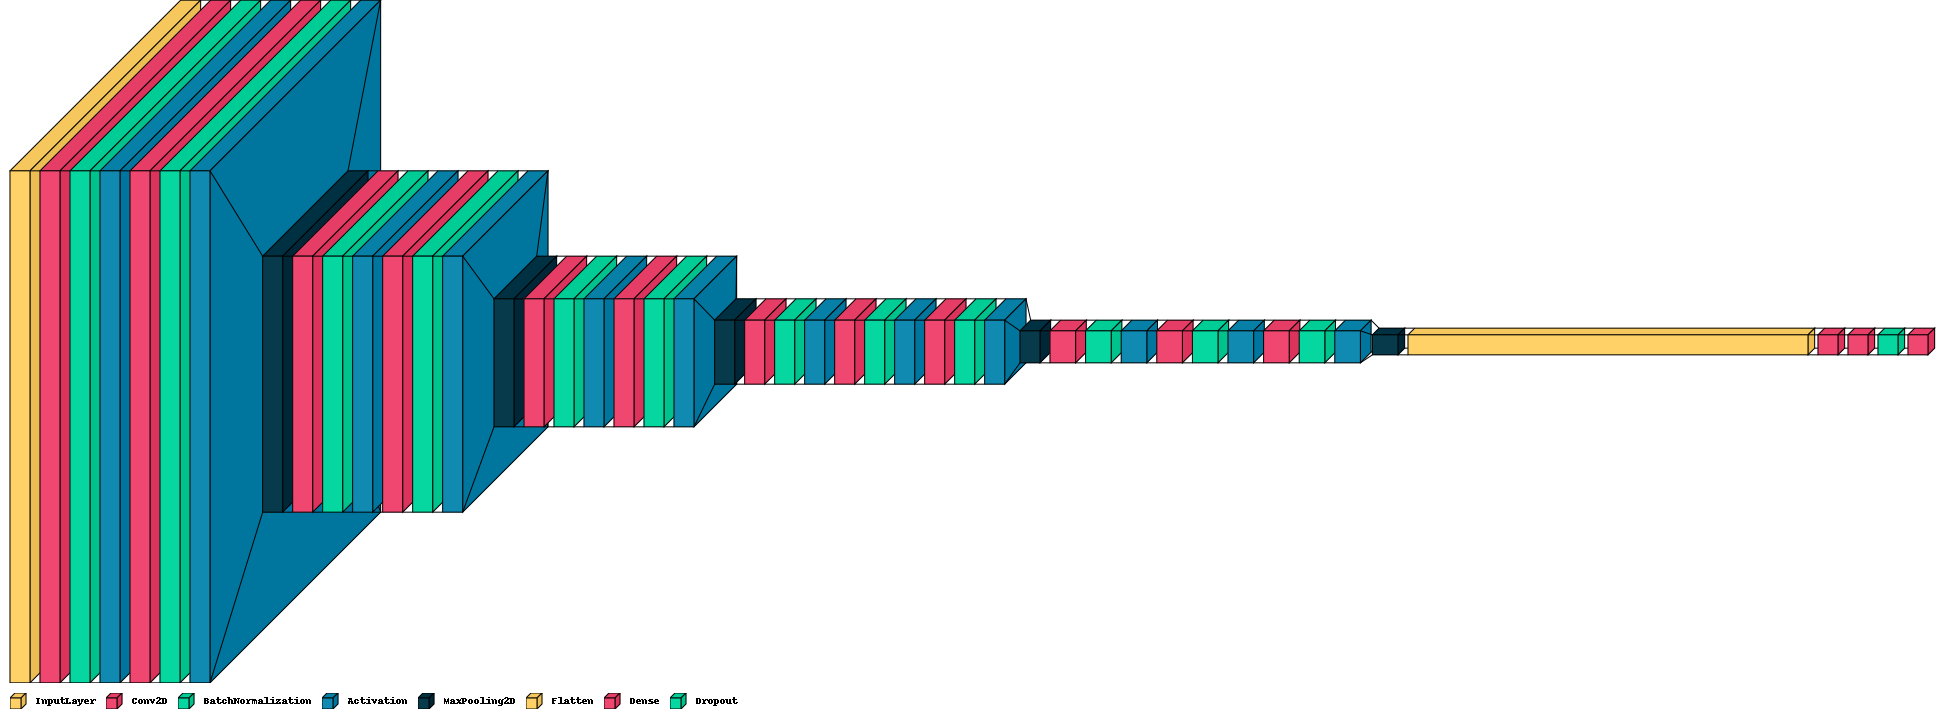

In [402]:
visualkeras.layered_view(final_model_128,legend=True, to_file="./images/final_model_128.png")


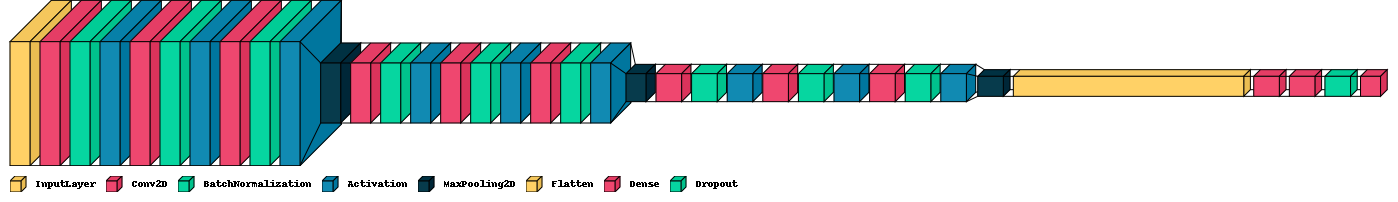

In [403]:
visualkeras.layered_view(final_model_31,legend=True, to_file="./images/final_model_31.png")

# Summary
To close off this project, this CNN project has been a great learning experience. The main focus was tweaking models for different picture sizes, like 31x31 and 128x128 pixels. Dealing with TensorFlow's batch dataset brought its own set of challenges, and getting everything just right took some time. This project taught me alot about CNNs and its architechture,while it wasn't always smooth sailing, these challenges gave me practical insights into how deep learning works in the real world.

![](./images/857226351e010e2e5fd31960b9dd73f3.jpg)